# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- Countries
    - [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
    - [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
    - [Time-series plots of infections in most infected countries](#time-series_countries)
    - [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
    - [Relative increases per day by country](#country_relative_increases)
    - [Time-series plots of mortality](#time-series_country_mortality)
    - [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
      - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
    - [Density of infections per million people](#density_of_infections_by_country)
    - [How many days behind is each country from Italy?](#days_behind)
- US states
    - [US states with the most new infections](#states_most_infections)
    - [Time-series plots of infections in most-infected states](#time-series_states)
    - [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
    - [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
    - [Compare US state infections against Washington](#state_infections_vs_wa)
    - [Compare US state infections against New York](#state_infections_vs_ny)
    - [Mortality rate by US state](#mortality_by_us_state)
    - [Relative increases per day by state](#us_state_relative_increases)
    - [When will each US state hit 1 case?](#us_state_0_new)
    - [Smoothed trend for each US state](#us_state_smoothed_trend)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [765]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [766]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [767]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-06-15 22:13:27.634075
metric: deaths at 2020-06-15 22:13:29.370843
Latest data from 2020-06-15


In [768]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [769]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-15              US    2114026          19968  116127         395   
1  2020-06-15          Brazil     888271          20647   43959         627   
2  2020-06-15  United Kingdom     298315            973   41821          38   
3  2020-06-15           Italy     237290            301   34371          26   
4  2020-06-15          France     194305            152   29439          29   
5  2020-06-15           Spain     244109            181   27136           0   
6  2020-06-15          Mexico     150264           3427   17580         439   
7  2020-06-15           India     343091          10667    9900         380   
8  2020-06-15         Belgium      60100             71    9661           6   
9  2020-06-15            Iran     189876           2449    8950         113   
10 2020-06-15         Germany     187682            164    8807           6   
11 2020-06-15          Canada     100763            359    8228          10   
12 2020-06-15          Russia     536484           8217    7081         143   
13 2020-06-15            Peru     232992           3256    6860         172   
14 2020-06-15     Netherlands      49155            165    6084           6   
15 2020-06-15          Sweden      52383            769    4891          17   
16 2020-06-15          Turkey     179831           1592    4825          18   
17 2020-06-15           China      84378             43    4638           0   
18 2020-06-15         Ecuador      47322            571    3929          33   
19 2020-06-15           Chile     179436           5143    3362          39   

    mortality_rate  
0         0.054932  
1         0.049488  
2         0.140191  
3         0.144848  
4         0.151509  
5         0.111163  
6         0.116994  
7         0.028855  
8         0.160749  
9         0.047136  
10        0.046925  
11        0.081657  
12        0.013199  
13        0.029443  
14        0.123772  
15        0.093370  
16        0.026831  
17        0.054967  
18        0.083027  
19        0.018736

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [770]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date       country  confirmed  confirmed_new  deaths  deaths_new  \
1  2020-06-15        Brazil     888271          20647   43959         627   
0  2020-06-15            US    2114026          19968  116127         395   
7  2020-06-15         India     343091          10667    9900         380   
12 2020-06-15        Russia     536484           8217    7081         143   
19 2020-06-15         Chile     179436           5143    3362          39   
32 2020-06-15  Saudi Arabia     132048           4507    1011          39   
20 2020-06-15      Pakistan     148921           4443    2839         110   
23 2020-06-15      Colombia      53168           4272    1808         138   
26 2020-06-15  South Africa      73533           3495    1568          88   
6  2020-06-15        Mexico     150264           3427   17580         439   

    mortality_rate  
1         0.049488  
0         0.054932  
7         0.028855  
12        0.013199  
19        0.018736  
32        0.007656  
20        0.019064  
23        0.034005  
26        0.021324  
6         0.116994

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [771]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

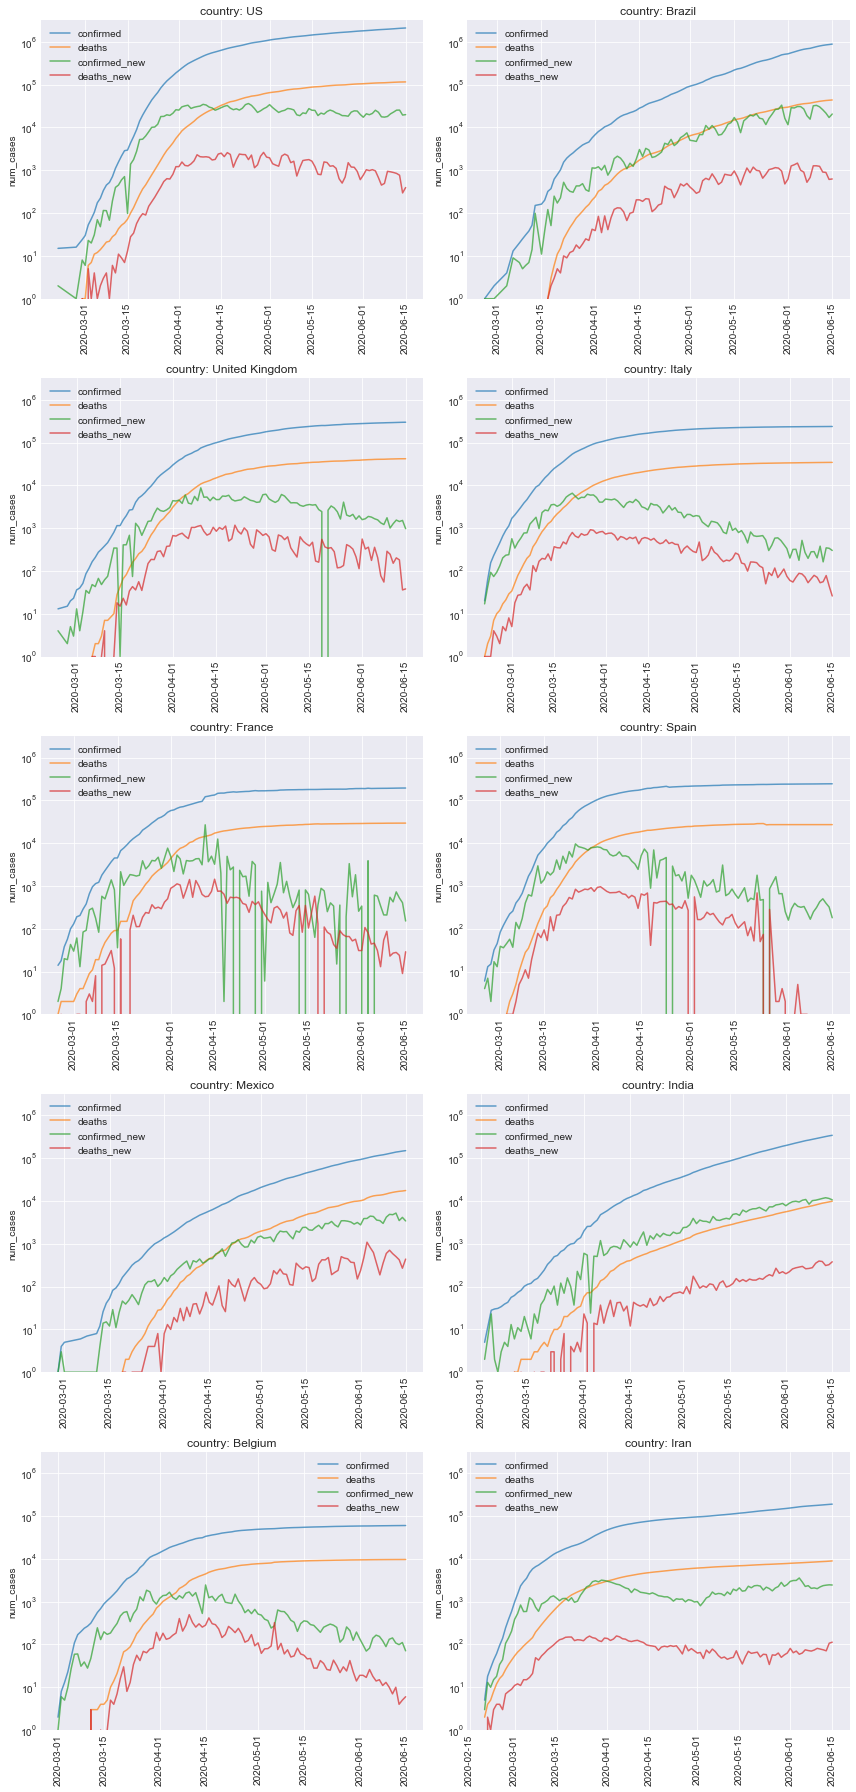

In [772]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

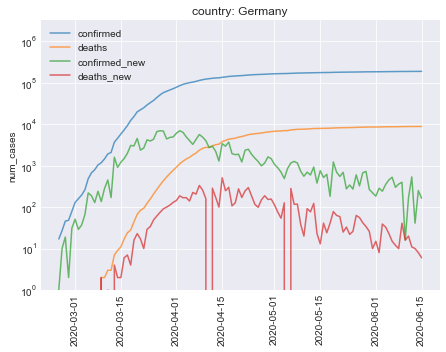

In [773]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [774]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1, cols_to_be_null_in_future=[]):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    cols_nullable = ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']
    cols_nullable.extend(cols_to_be_null_in_future)
    for col in cols_nullable:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-06-16 2020-06-22 2020-07-06  2020-06-16 2020-06-22   
country                                                                      
US                  2141008.0  2289418.0  2676953.0    117213.0   121593.0   
Brazil               924474.0  1106812.0  1684581.0     45378.0    51874.0   
United Kingdom       299835.0   308171.0   328534.0     42081.0    42979.0   
Italy                237551.0   239312.0   243472.0     34449.0    34792.0   
France               195047.0   198052.0   205245.0     29463.0    29603.0   
Spain                244636.0   246938.0   252393.0     27136.0    27135.0   
Mexico               156427.0   189223.0   295025.0     18285.0    21814.0   
India                357143.0   444724.0   741884.0     10358.0    13212.0   
Belgium               60244.0    60920.0    62529.0      9669.0     9711.0   
Iran                 192239.0   207616.0   248450.0      9015.0     9561.0   

                          mortality_rate_pred                        \
date           2020-07-06          2020-06-16 2020-06-22 2020-07-06   
country                                                               
US               132458.0            0.054747   0.053111   0.049481   
Brazil            70878.0            0.049085   0.046868   0.042075   
United Kingdom    45149.0            0.140347   0.139465   0.137426   
Italy             35604.0            0.145017   0.145383   0.146234   
France            29931.0            0.151056   0.149471   0.145831   
Spain             27135.0            0.110924   0.109886   0.107511   
Mexico            32928.0            0.116892   0.115282   0.111611   
India             23316.0            0.029002   0.029708   0.031428   
Belgium            9808.0            0.160497   0.159406   0.156855   
Iran              10968.0            0.046895   0.046051   0.044146   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.011233         6.132398e-03  
Brazil                        0.030457         2.254656e-02  
United Kingdom                0.004581         3.524421e-03  
Italy                         0.001232         1.650564e-03  
France                        0.002551         7.883236e-04  
Spain                         0.001562        -1.110223e-16  
Mexico                        0.032232         2.984917e-02  
India                         0.037229         4.140281e-02  
Belgium                       0.001863         7.115197e-04  
Iran                          0.012908         9.854195e-03

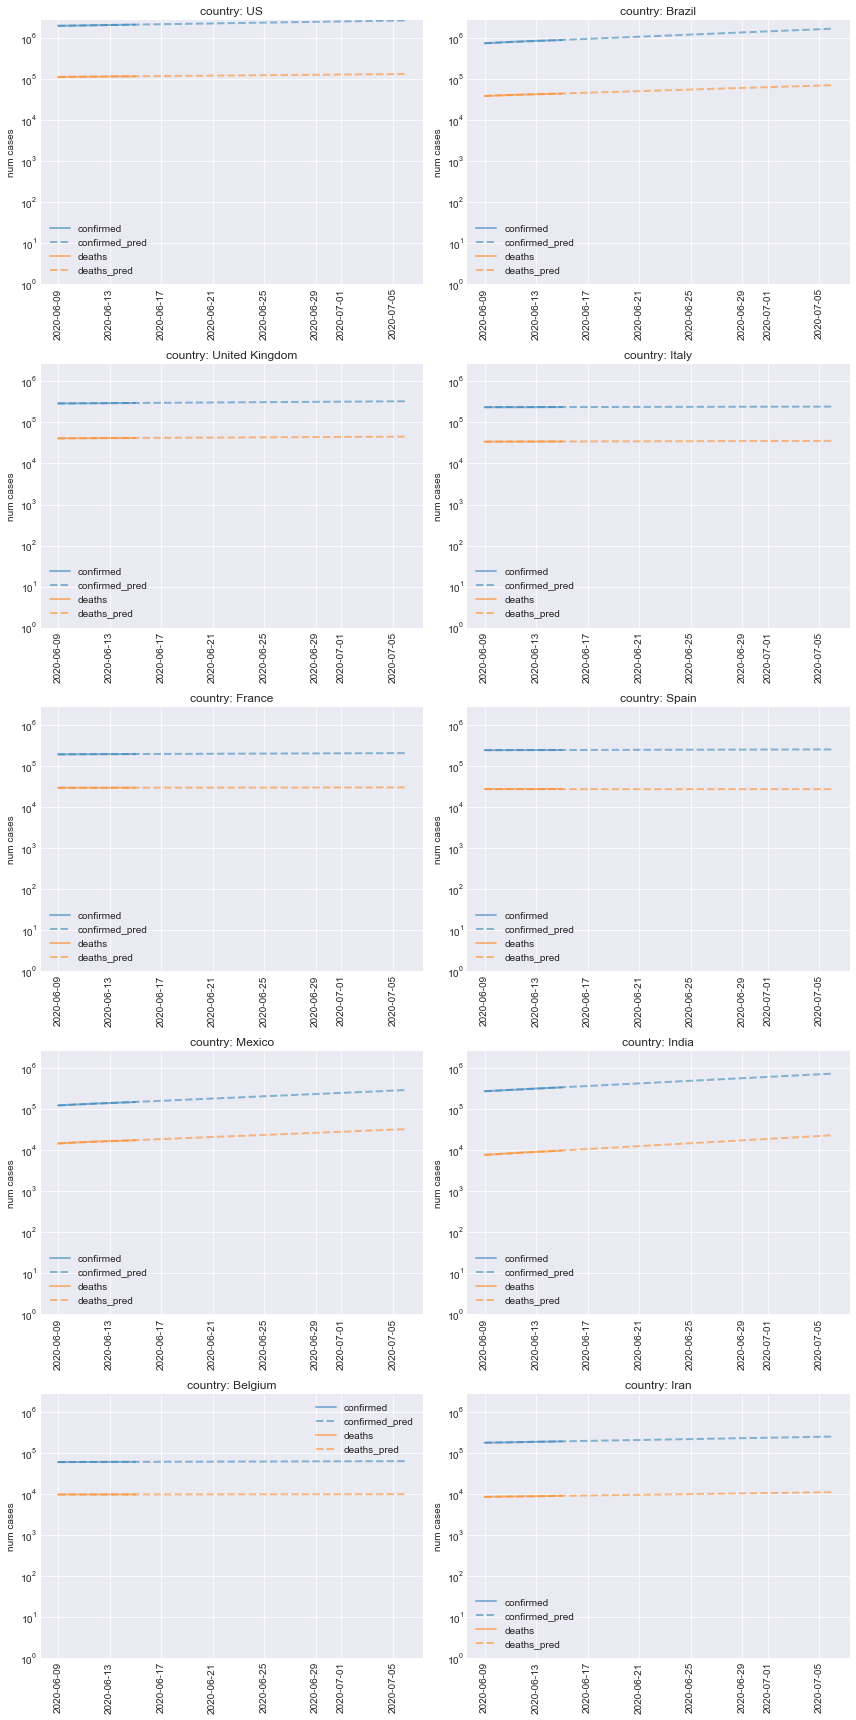

In [775]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [776]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-15_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [777]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


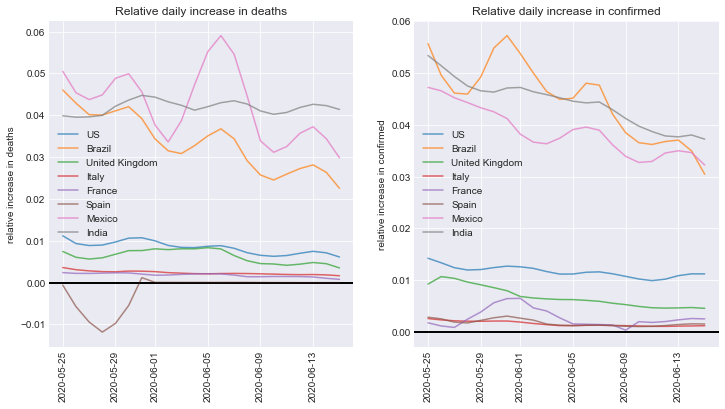

In [778]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-06-16 2020-06-22  2020-06-16 2020-06-22   
country                                                           
US                  2138472.0  2280958.0    117493.0   122347.0   
Brazil               946525.0  1174783.0     46031.0    53806.0   
United Kingdom       300334.0   309394.0     42237.0    43387.0   
Italy                237541.0   239267.0     34489.0    34894.0   
France               194564.0   196809.0     29516.0    29745.0   
Spain                244425.0   246370.0     27138.0    27141.0   
Mexico               157559.0   192624.0     18755.0    23204.0   
India                360364.0   454282.0     10370.0    13243.0   
Belgium               60285.0    61028.0      9690.0     9761.0   
Iran                 193104.0   209626.0      8986.0     9484.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-06-16 2020-06-22                           
country                                                                 
US                        0.054943   0.053638                0.010809   
Brazil                    0.048632   0.045801                0.036663   
United Kingdom            0.140633   0.140232                0.004966   
Italy                     0.145192   0.145837                0.001207   
France                    0.151703   0.151136                0.001914   
Spain                     0.111028   0.110164                0.001322   
Mexico                    0.119035   0.120463                0.034057   
India                     0.028776   0.029151                0.039355   
Belgium                   0.160737   0.159943                0.002044   
Iran                      0.046535   0.045242                0.013776   

               frac_increase_deaths  
date                                 
country                              
US                         0.006770  
Brazil                     0.026352  
United Kingdom             0.004485  
Italy                      0.001949  
France                     0.001290  
Spain                      0.000020  
Mexico                     0.036109  
India                      0.041593  
Belgium                    0.001230  
Iran                       0.009026

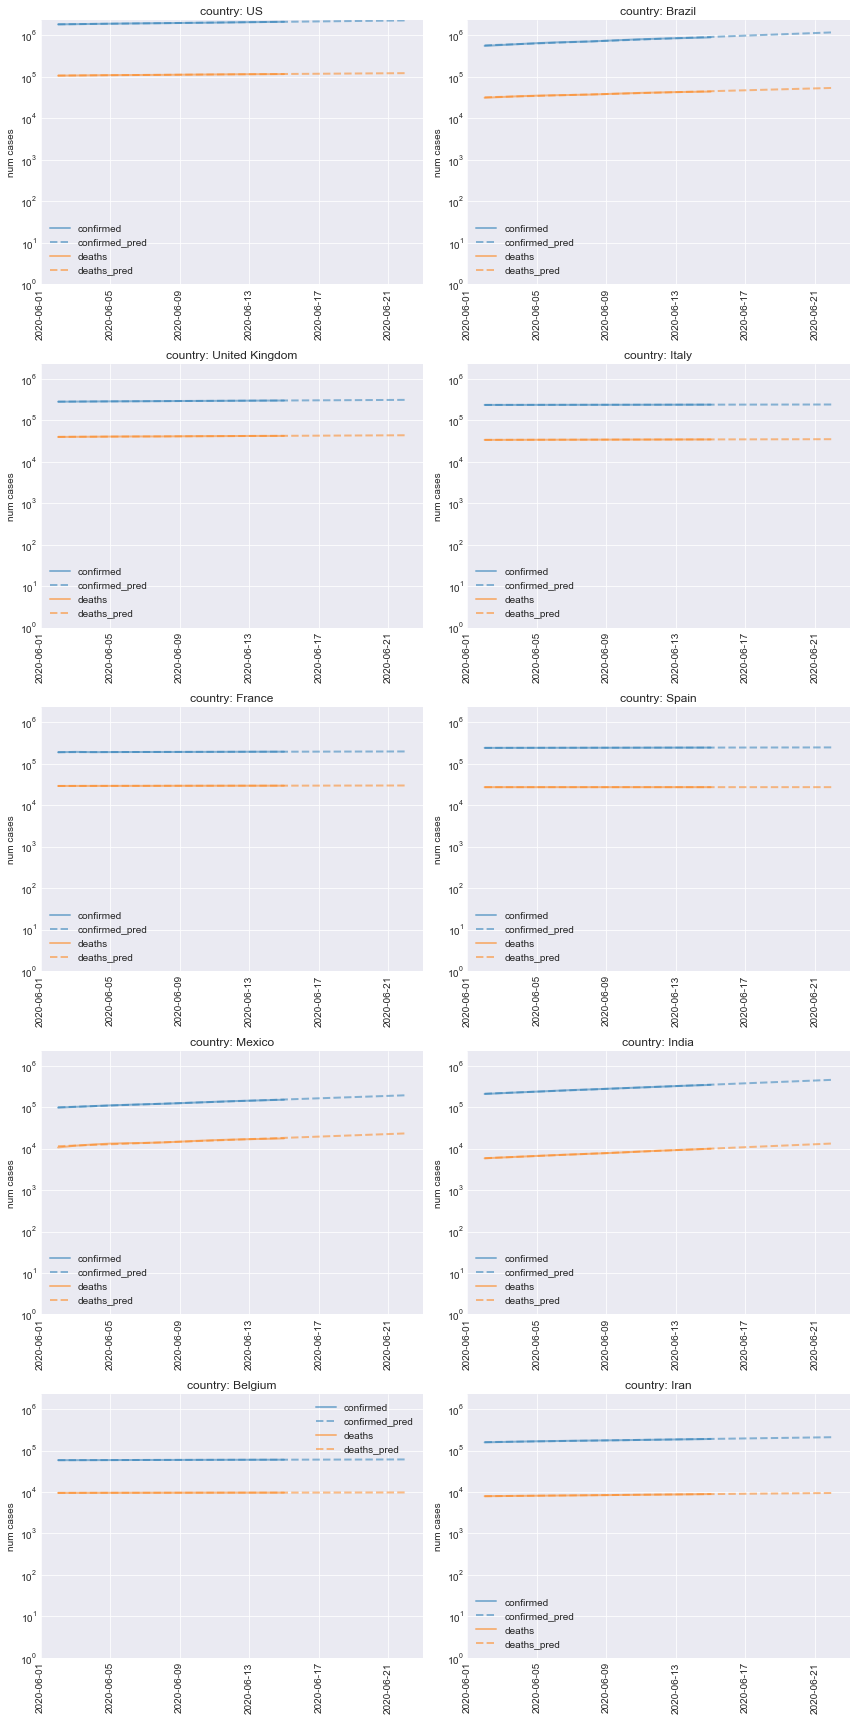

In [779]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [780]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-15_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [781]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

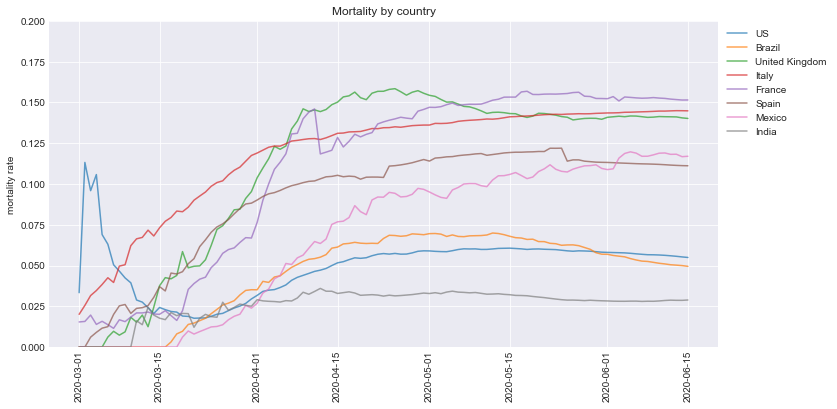

In [782]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [783]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

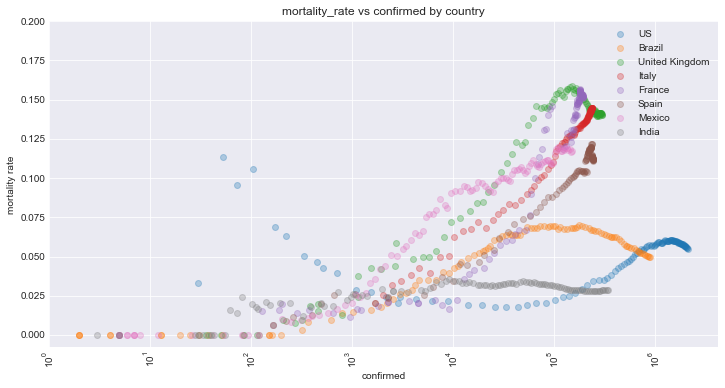

In [784]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [785]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

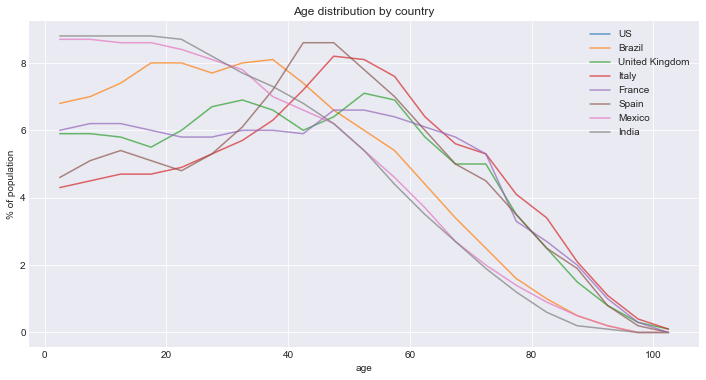

In [786]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

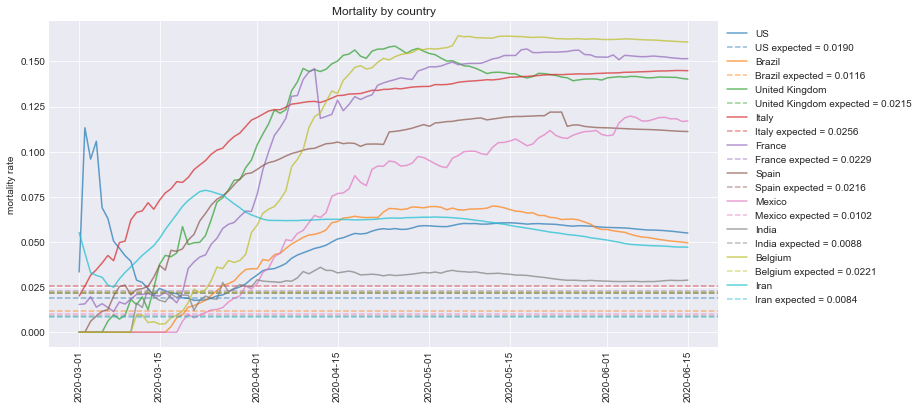

date         country  mortality_rate  confirmed    deaths
0 2020-06-15         Belgium        0.160749    60100.0    9661.0
1 2020-06-15          France        0.151509   194305.0   29439.0
2 2020-06-15           Italy        0.144848   237290.0   34371.0
3 2020-06-15  United Kingdom        0.140191   298315.0   41821.0
4 2020-06-15          Mexico        0.116994   150264.0   17580.0
5 2020-06-15           Spain        0.111163   244109.0   27136.0
6 2020-06-15              US        0.054932  2114026.0  116127.0
7 2020-06-15          Brazil        0.049488   888271.0   43959.0
8 2020-06-15            Iran        0.047136   189876.0    8950.0
9 2020-06-15           India        0.028855   343091.0    9900.0

In [787]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

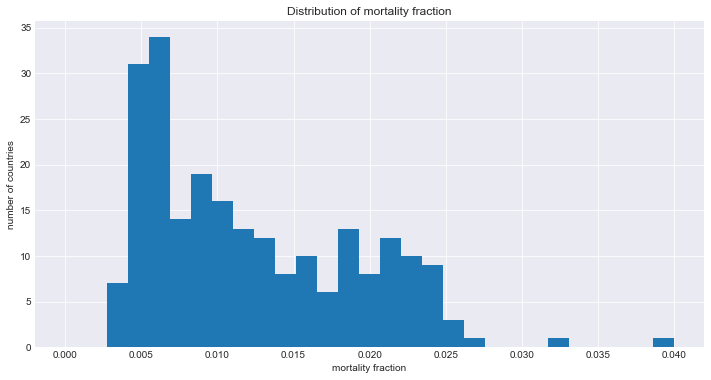

In [788]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [789]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [790]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

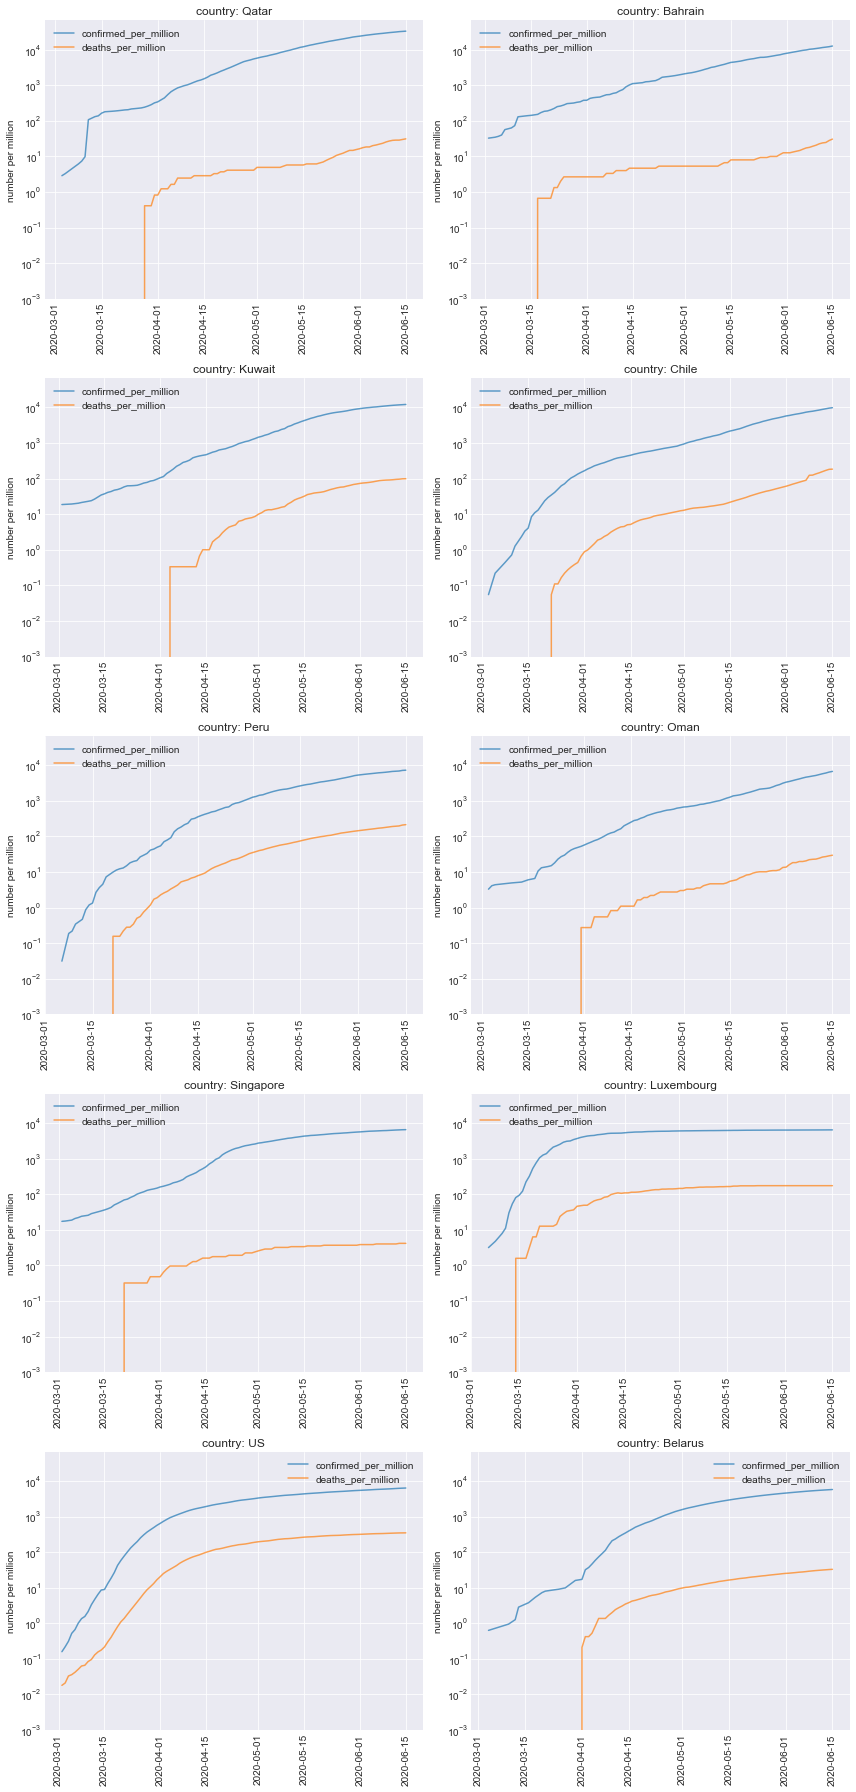

country   population  confirmed    deaths  confirmed_per_million  \
0       Qatar    2444174.0    80876.0      76.0           33089.297243   
1     Bahrain    1505003.0    19013.0      46.0           12633.197409   
2      Kuwait    2993706.0    36431.0     298.0           12169.197643   
3       Chile   18186770.0   179436.0    3362.0            9866.292915   
4        Peru   31914989.0   232992.0    6860.0            7300.394182   
5        Oman    3634689.0    24524.0     108.0            6747.207258   
6   Singapore    6209660.0    40818.0      26.0            6573.306751   
7  Luxembourg     628381.0     4072.0     110.0            6480.145008   
8          US  332639102.0  2114026.0  116127.0            6355.314175   
9     Belarus    9477918.0    54680.0     312.0            5769.199523   

   deaths_per_million  mortality_rate  
0           31.094349        0.000940  
1           30.564723        0.002419  
2           99.542173        0.008180  
3          184.859653        0.018736  
4          214.946024        0.029443  
5           29.713684        0.004404  
6            4.187025        0.000637  
7          175.053033        0.027014  
8          349.108085        0.054932  
9           32.918622        0.005706

In [791]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [792]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop  confirmed    deaths  confirmed_per_million  \
15         Belgium   11720716.0    60100.0    9661.0            5127.673088   
19  United Kingdom   65761117.0   298315.0   41821.0            4536.343262   
23           Italy   62402659.0   237290.0   34371.0            3802.562324   
18           Spain   50015792.0   244109.0   27136.0            4880.638499   
14          Sweden   10202491.0    52383.0    4891.0            5134.334350   
29          France   67848156.0   194305.0   29439.0            2863.821384   
30     Netherlands   17280397.0    49155.0    6084.0            2844.552703   
8               US  332639102.0  2114026.0  116127.0            6355.314175   
16         Ireland    5176569.0    25321.0    1706.0            4891.463825   
31         Ecuador   16904867.0    47322.0    3929.0            2799.312174   

    deaths_per_million  mortality_rate  
15          824.267050        0.160749  
19          635.953310        0.140191  
23          550.793837        0.144848  
18          542.548641        0.111163  
14          479.392729        0.093370  
29          433.895359        0.151509  
30          352.075245        0.123772  
8           349.108085        0.054932  
16          329.561916        0.067375  
31          232.418273        0.083027

### Mortality rate by deaths per capita, confirmed per capita

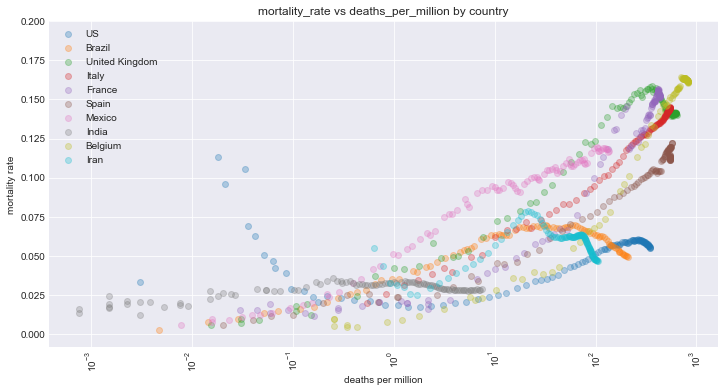

In [793]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

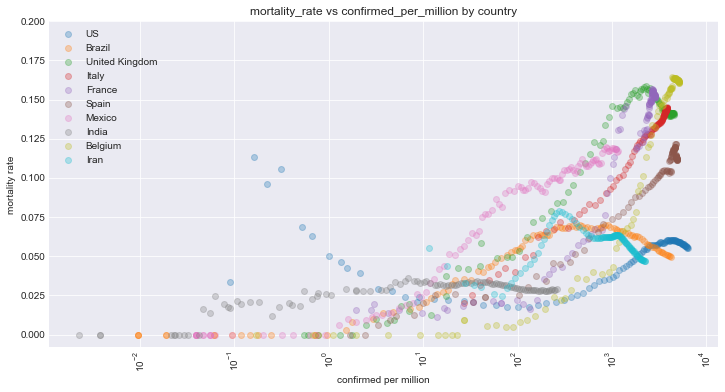

In [794]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [795]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

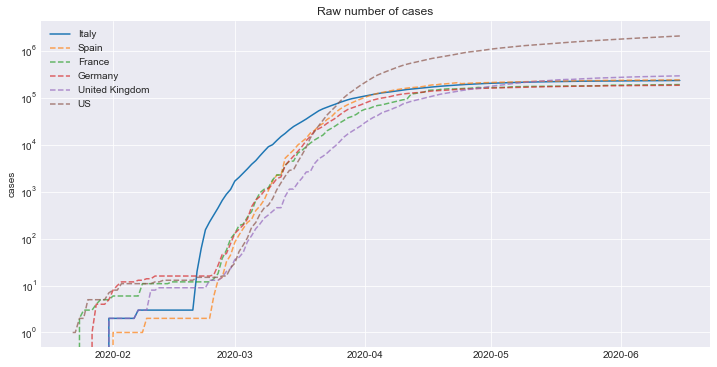

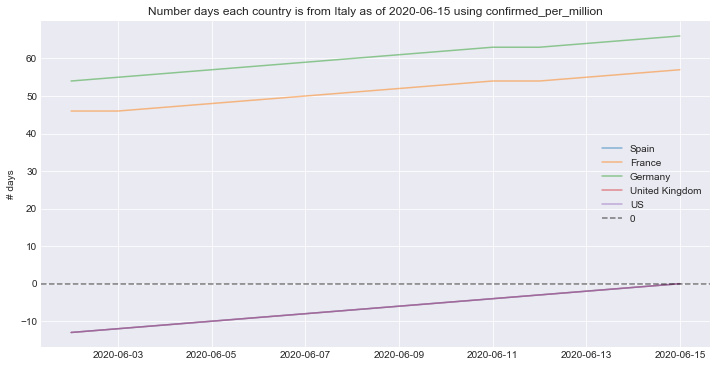

In [796]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

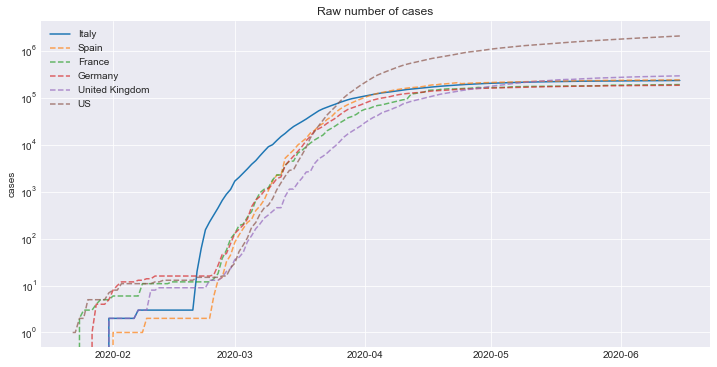

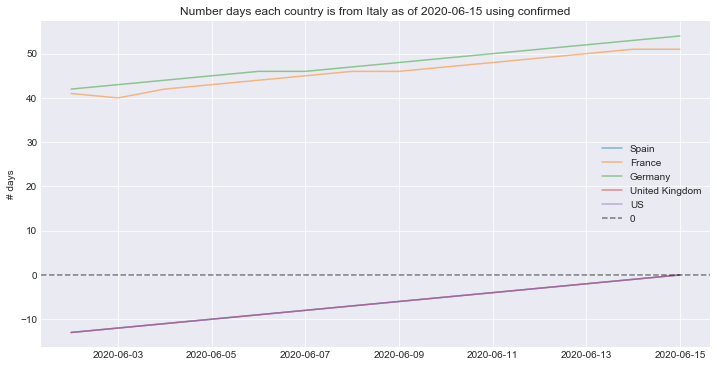

In [797]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [798]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [799]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [800]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [801]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [802]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-16       New York     383944            620   30856          31   
1  2020-06-16     New Jersey     167103            222   12708          49   
2  2020-06-16  Massachusetts     105690             87    7647          23   
3  2020-06-16       Illinois     133016            473    6326          18   
4  2020-06-16   Pennsylvania      83589            386    6243          28   
5  2020-06-16       Michigan      66085             31    6018           2   
6  2020-06-16     California     155726           3426    5114          15   
7  2020-06-16    Connecticut      45235            147    4204           3   
8  2020-06-16      Louisiana      47172            553    3018           4   
9  2020-06-16       Maryland      62032            331    2947           8   
10 2020-06-16        Florida      77326           1758    2938           7   
11 2020-06-16           Ohio      41576            428    2575          16   
12 2020-06-16        Georgia      58414            733    2494          43   
13 2020-06-16        Indiana      40430            521    2433          11   
14 2020-06-16          Texas      90211           1688    2001          17   

    mortality_rate  
0         0.080366  
1         0.076049  
2         0.072353  
3         0.047558  
4         0.074687  
5         0.091065  
6         0.032840  
7         0.092937  
8         0.063979  
9         0.047508  
10        0.037995  
11        0.061935  
12        0.042695  
13        0.060178  
14        0.022181

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [803]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

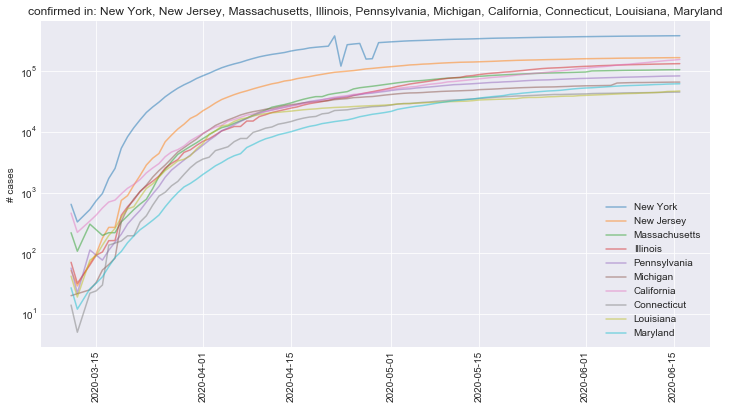

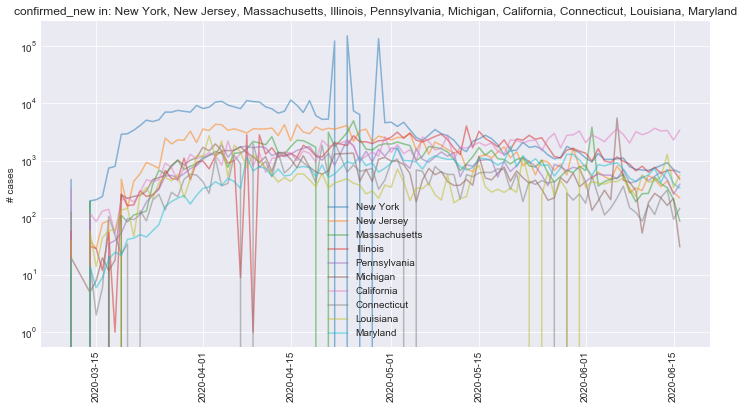

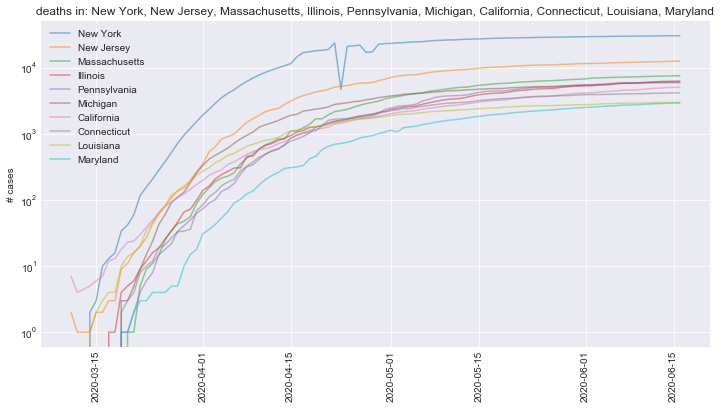

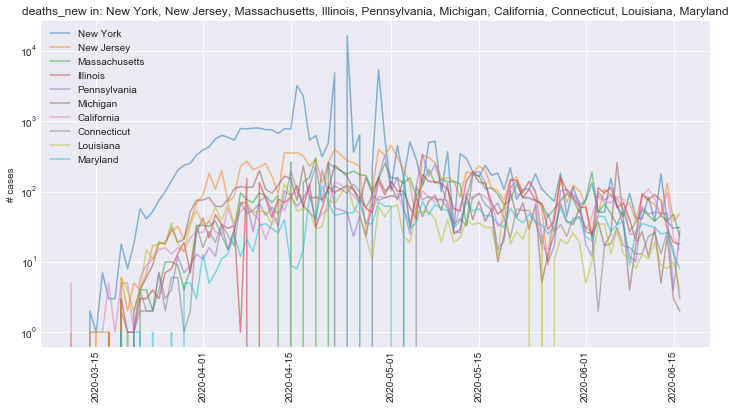

In [804]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

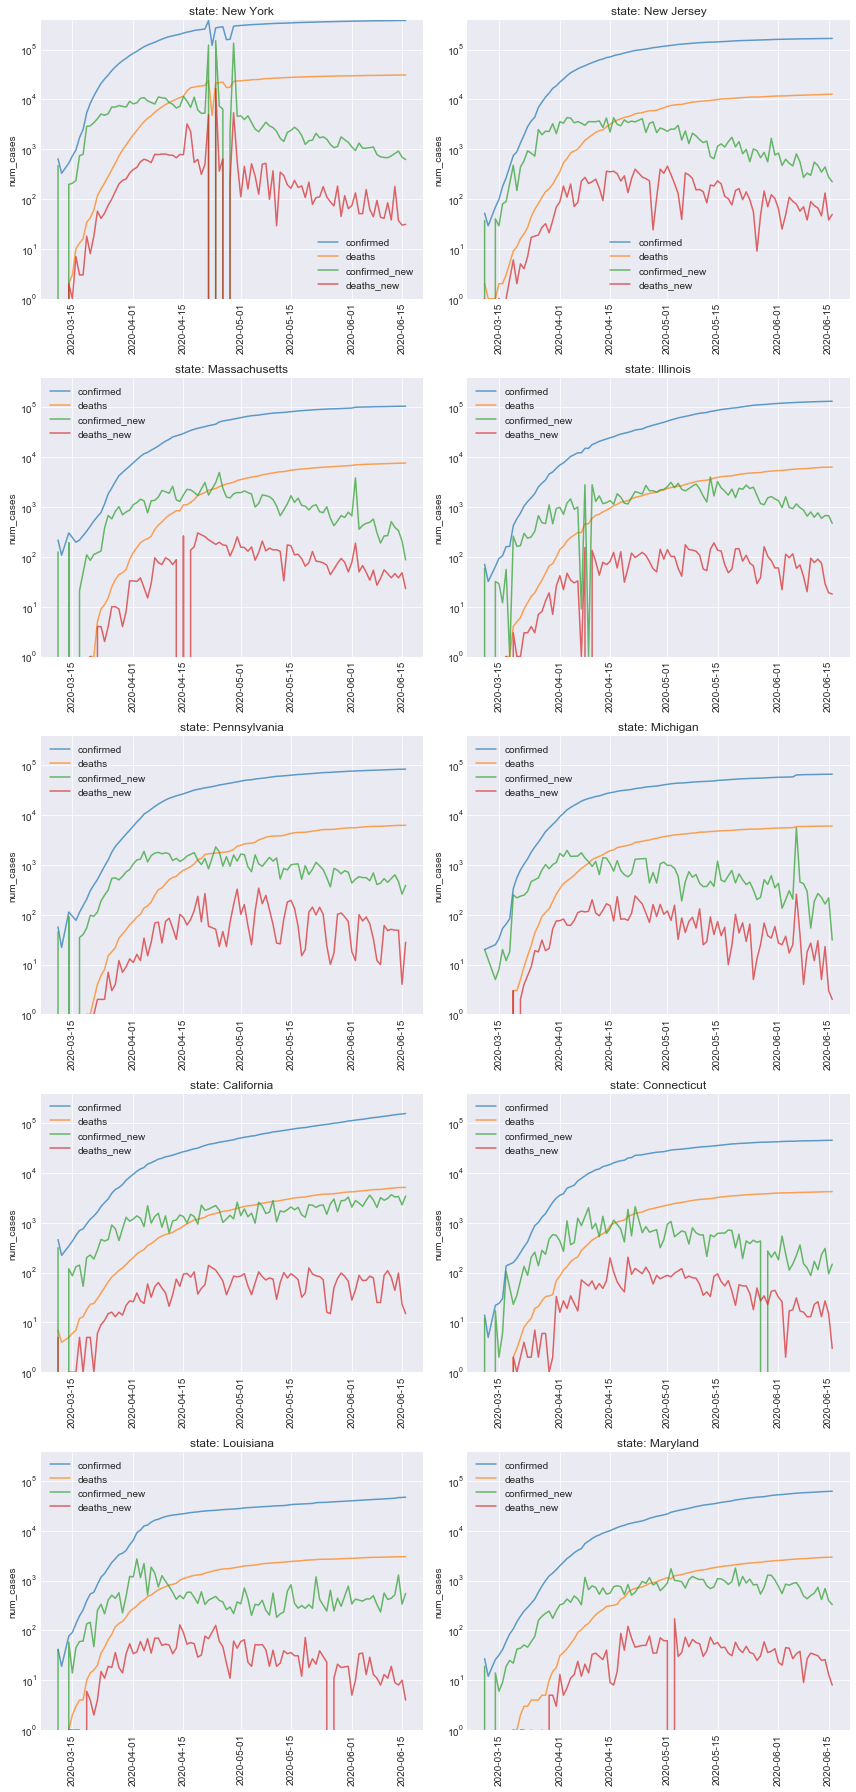

In [805]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

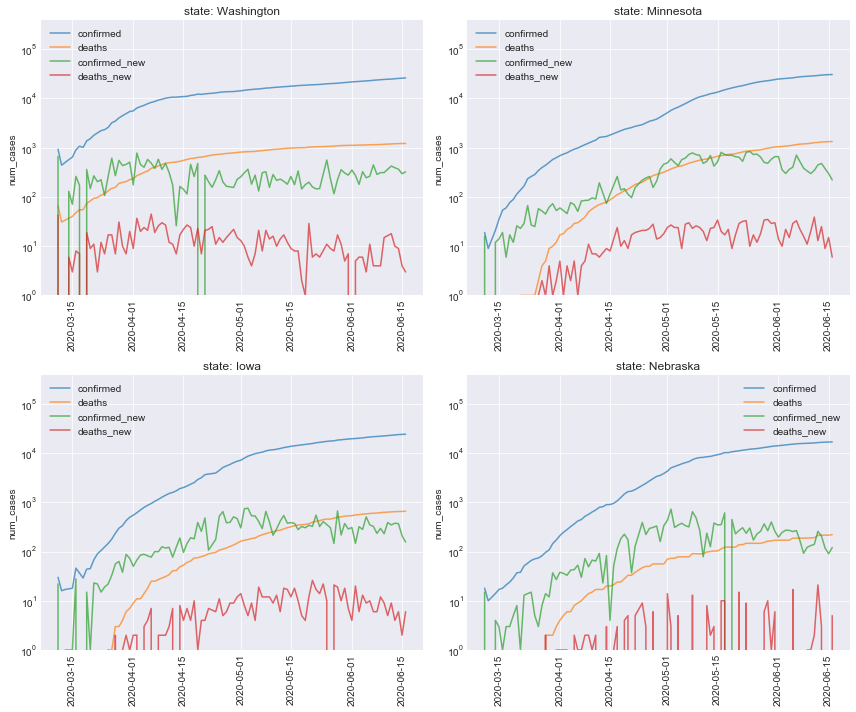

In [806]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-06-17 2020-06-23 2020-07-07  2020-06-17 2020-06-23   
state                                                                       
New York            384809.0   389473.0   400576.0     30970.0    31401.0   
New Jersey          167647.0   169996.0   175606.0     12796.0    13232.0   
Massachusetts       106218.0   108196.0   112955.0      7698.0     7952.0   
Illinois            133787.0   137801.0   147642.0      6422.0     6754.0   
Pennsylvania         84200.0    87106.0    94285.0      6303.0     6548.0   
Michigan             66384.0    67565.0    70400.0      6042.0     6124.0   
California          159521.0   181797.0   246630.0      5225.0     5634.0   
Connecticut          45458.0    46601.0    49382.0      4234.0     4350.0   
Louisiana            47886.0    52055.0    63250.0      3033.0     3098.0   
Maryland             62771.0    66187.0    74898.0      2985.0     3133.0   

                         mortality_rate_pred                        \
date          2020-07-07          2020-06-17 2020-06-23 2020-07-07   
state                                                                
New York         32428.0            0.080481   0.080624   0.080953   
New Jersey       14308.0            0.076327   0.077837   0.081478   
Massachusetts     8578.0            0.072474   0.073496   0.075942   
Illinois          7597.0            0.048002   0.049013   0.051456   
Pennsylvania      7157.0            0.074857   0.075173   0.075908   
Michigan          6319.0            0.091016   0.090639   0.089759   
California        6717.0            0.032754   0.030991   0.027235   
Connecticut       4632.0            0.093141   0.093346   0.093799   
Louisiana         3253.0            0.063338   0.059514   0.051431   
Maryland          3506.0            0.047554   0.047336   0.046810   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.002010             0.002303  
New Jersey                   0.002322             0.005602  
Massachusetts                0.003079             0.005426  
Illinois                     0.004939             0.008432  
Pennsylvania                 0.005673             0.006373  
Michigan                     0.002941             0.002241  
California                   0.022025             0.012634  
Connecticut                  0.004149             0.004506  
Louisiana                    0.014011             0.003495  
Maryland                     0.008871             0.008070

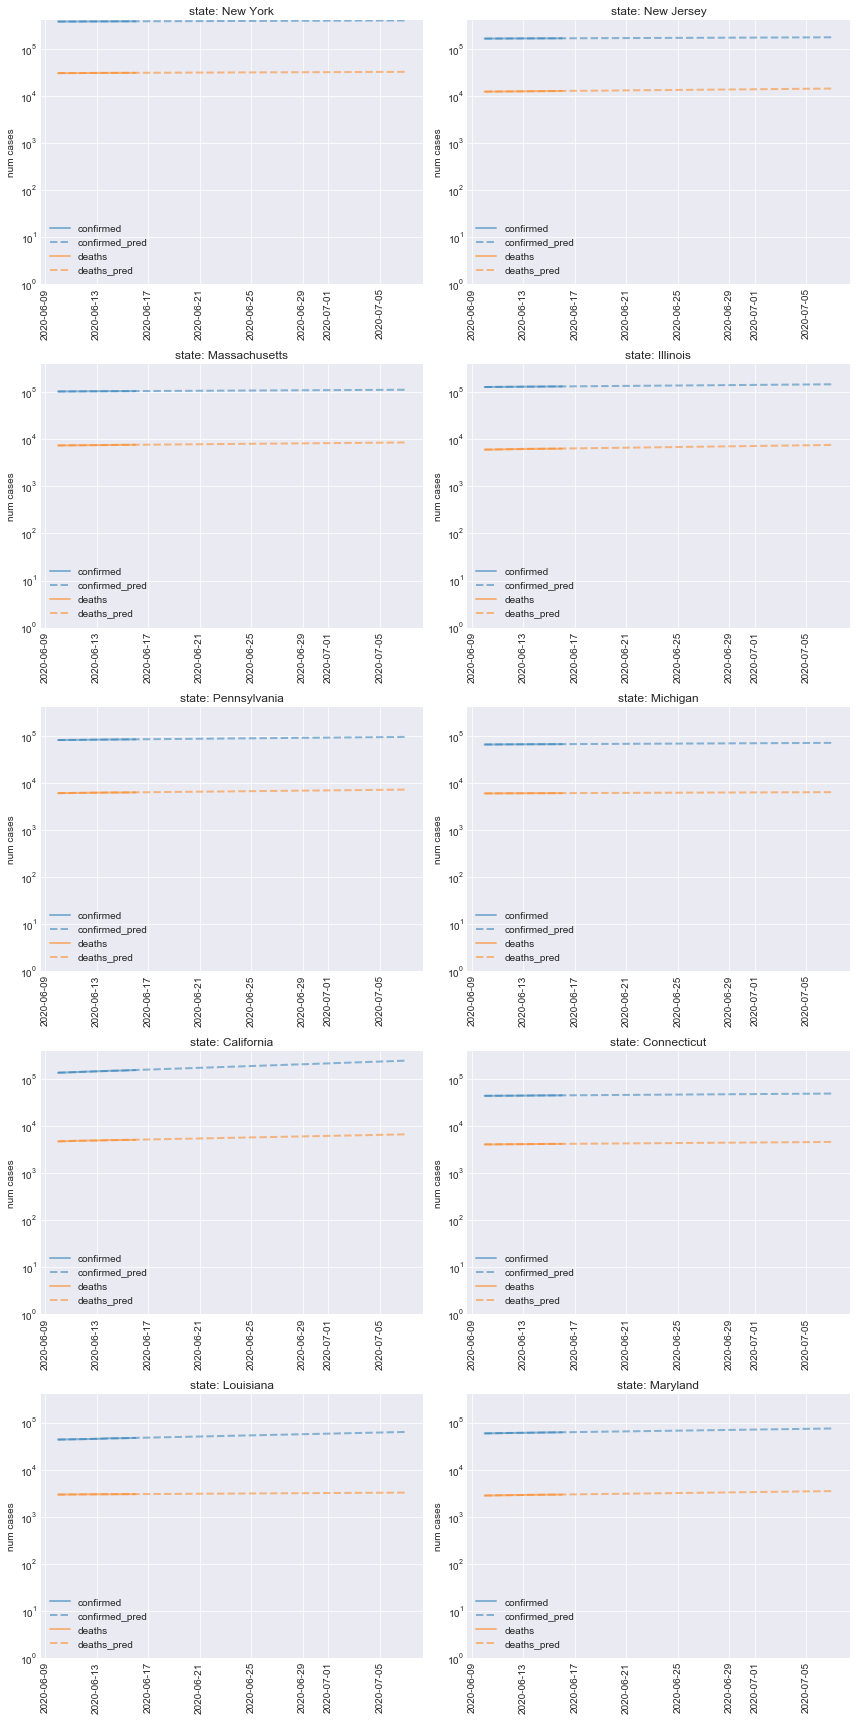

In [807]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-06-17 2020-06-23 2020-07-07  2020-06-17 2020-06-23   
state                                                                       
New York            385122.0   390172.0   402215.0     30974.0    31402.0   
New Jersey          167866.0   170512.0   176852.0     12806.0    13255.0   
Massachusetts       106390.0   108587.0   113892.0      7709.0     7983.0   
Illinois            134433.0   139429.0   151821.0      6473.0     6894.0   
Pennsylvania         84373.0    87556.0    95457.0      6323.0     6598.0   
Michigan             68576.0    72873.0    83974.0      6147.0     6379.0   
California          159739.0   182418.0   248658.0      5248.0     5701.0   
Connecticut          45452.0    46555.0    49232.0      4235.0     4351.0   
Louisiana            47386.0    50655.0    59186.0      3047.0     3131.0   
Maryland             63162.0    67148.0    77453.0      3006.0     3190.0   

                         mortality_rate_pred                        \
date          2020-07-07          2020-06-17 2020-06-23 2020-07-07   
state                                                                
New York         32425.0            0.080426   0.080482   0.080616   
New Jersey       14366.0            0.076287   0.077736   0.081232   
Massachusetts     8658.0            0.072460   0.073517   0.076019   
Illinois          7985.0            0.048150   0.049445   0.052595   
Pennsylvania      7286.0            0.074941   0.075357   0.076328   
Michigan          6956.0            0.089638   0.087536   0.082835   
California        6918.0            0.032854   0.031252   0.027821   
Connecticut       4636.0            0.093175   0.093459   0.094166   
Louisiana         3336.0            0.064302   0.061810   0.056365   
Maryland          3664.0            0.047592   0.047507   0.047306   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.002174             0.002291  
New Jersey                   0.002611             0.005765  
Massachusetts                0.003413             0.005820  
Illinois                     0.006100             0.010549  
Pennsylvania                 0.006190             0.007109  
Michigan                     0.010180             0.006199  
California                   0.022373             0.013912  
Connecticut                  0.004002             0.004532  
Louisiana                    0.011180             0.004543  
Maryland                     0.010251             0.009940

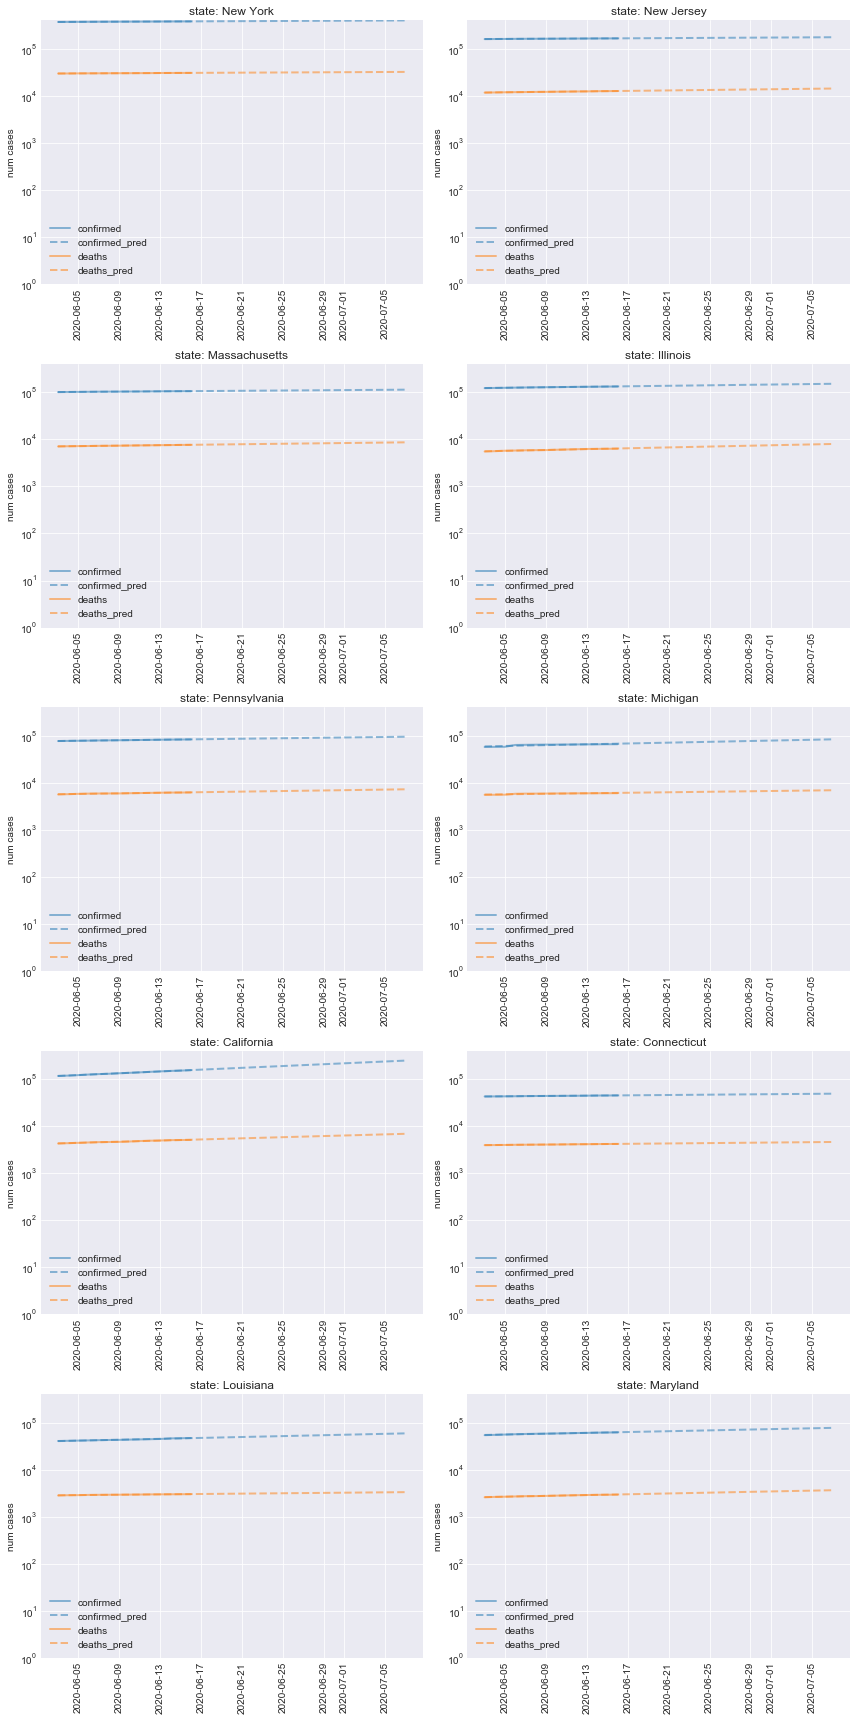

In [808]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [809]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [810]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-06-16              Nebraska      16851     220           5   
1  2020-06-16                  Utah      14608     143           4   
2  2020-06-16              Arkansas      12917     182           3   
3  2020-06-16               Arizona      36844    1203          12   
4  2020-06-16                Alaska        663      12           0   
5  2020-06-16             Tennessee      31004     482           8   
6  2020-06-16          South Dakota       5928      75           0   
7  2020-06-16         New Hampshire       5345     320           0   
8  2020-06-16            New Mexico       9845     440           5   
9  2020-06-16               Georgia      58414    2494          43   
10 2020-06-16             Minnesota      30693    1335           6   
11 2020-06-16            California     155726    5114          15   
12 2020-06-16                 Texas      90211    2001          17   
13 2020-06-16               Florida      77326    2938           7   
14 2020-06-16                  Ohio      41576    2575          16   
15 2020-06-16        North Carolina      45114    1140           8   
16 2020-06-16               Alabama      26272     774           1   
17 2020-06-16               Montana        609      19           0   
18 2020-06-16        South Carolina      19378     602           2   
19 2020-06-16              Kentucky      12647     505           6   
20 2020-06-16              Missouri      16611     887           2   
21 2020-06-16           Mississippi      19799     895           4   
22 2020-06-16                Oregon       5820     180           7   
23 2020-06-16                  Iowa      24082     658           6   
24 2020-06-16              Illinois     133016    6326          18   
25 2020-06-16          Rhode Island      16093     851          18   
26 2020-06-16             Wisconsin      22932     694           2   
27 2020-06-16              Maryland      62032    2947           8   
28 2020-06-16         West Virginia       2322      88           0   
29 2020-06-16               Indiana      40430    2433          11   
30 2020-06-16            Washington      26158    1220           3   
31 2020-06-16                Nevada      11315     465           2   
32 2020-06-16  District of Columbia       9799     515           0   
33 2020-06-16                Kansas      11319     246           1   
34 2020-06-16               Wyoming       1079      18           0   
35 2020-06-16            New Jersey     167103   12708          49   
36 2020-06-16          Pennsylvania      83589    6243          28   
37 2020-06-16           Puerto Rico       5890     147           0   
38 2020-06-16              Virginia      54886    1552           6   
39 2020-06-16           Connecticut      45235    4204           3   
40 2020-06-16              Delaware      10340     423           1   
41 2020-06-16              Colorado      29284    1605           7   
42 2020-06-16         Massachusetts     105690    7647          23   
43 2020-06-16                 Idaho       3399      87           0   
44 2020-06-16          North Dakota       3101      74           0   
45 2020-06-16             Louisiana      47172    3018           4   
46 2020-06-16              New York     383944   30856          31   
47 2020-06-16              Oklahoma       8417     359           0   
48 2020-06-16              Michigan      66085    6018           2   
49 2020-06-16                 Maine       2810     101           1   
50 2020-06-16        Virgin Islands         72       6           0   
51 2020-06-16                  Guam        185       5           0   
52 2020-06-16                Hawaii        736      17           0   
53 2020-06-16        Grand Princess        103       3           0   
54 2020-06-16               Vermont       1128      55           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.010         

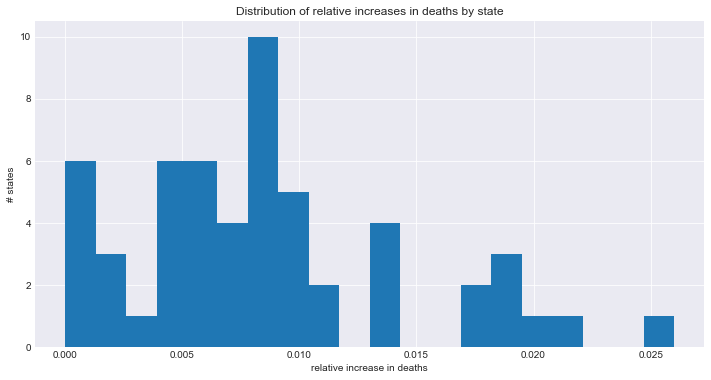

In [811]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

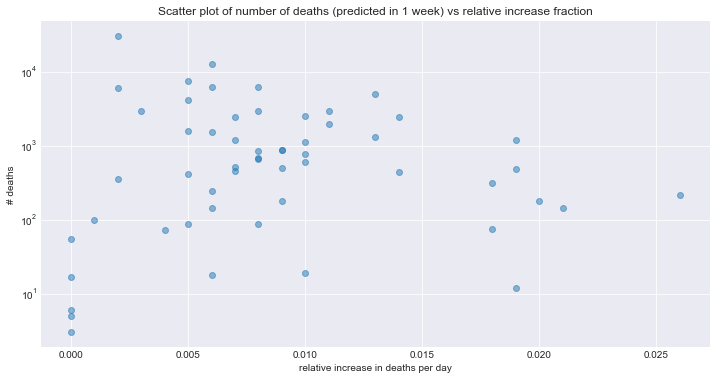

In [812]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [813]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

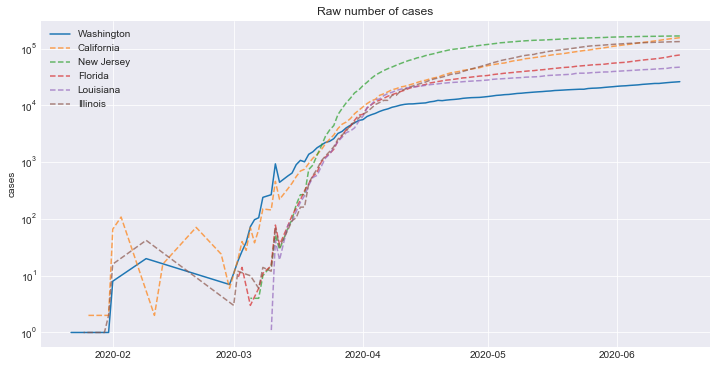

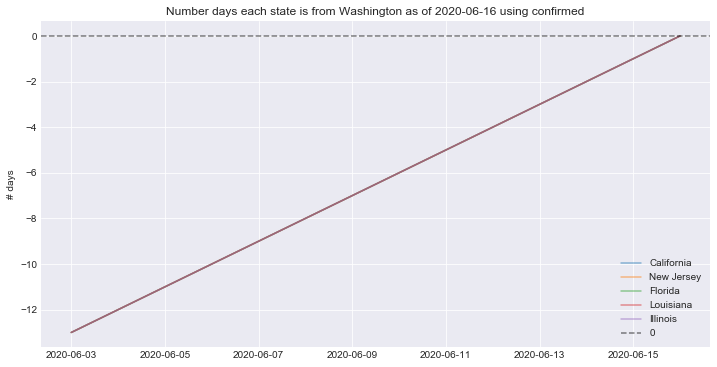

In [814]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

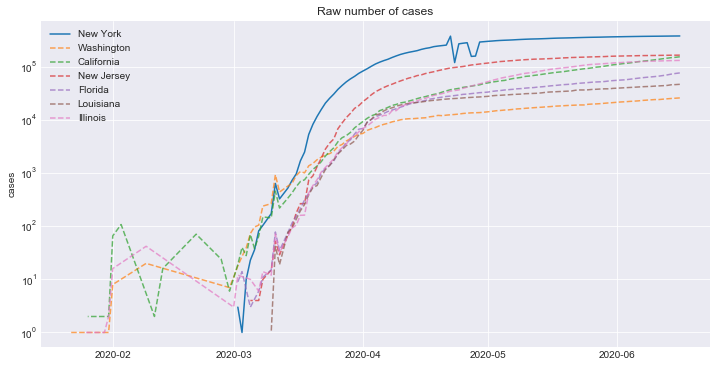

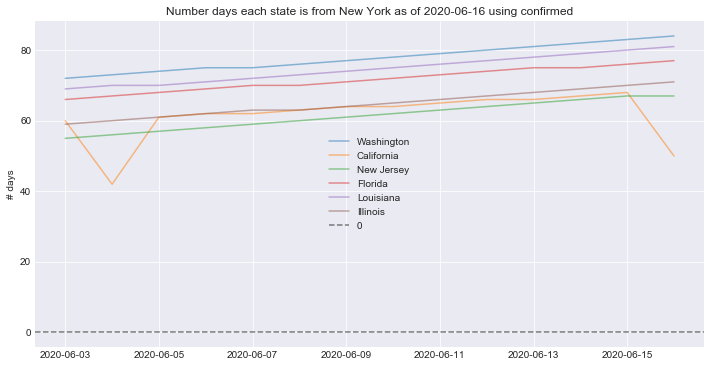

In [815]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

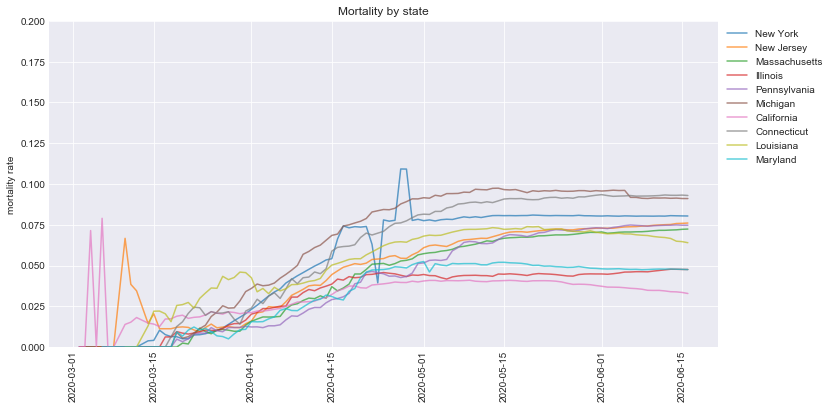

In [816]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

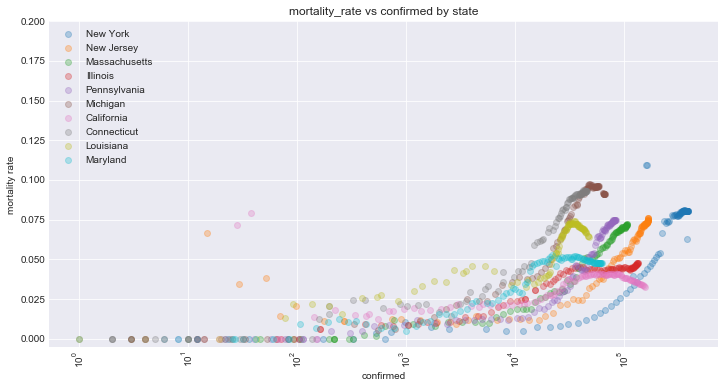

In [817]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

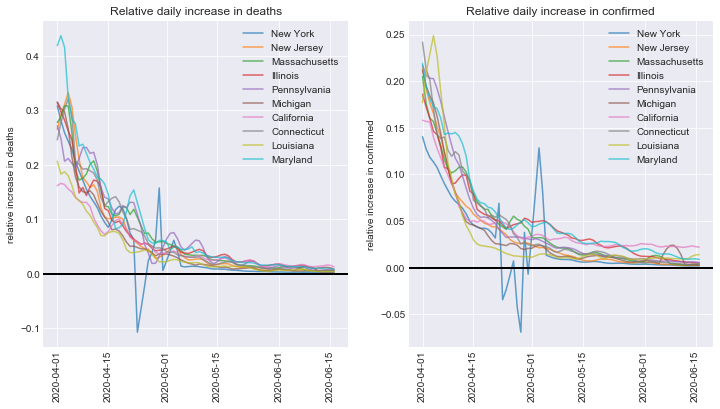

In [818]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [819]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n, cols_to_be_null_in_future=fit_cols)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                       cols_deaths='deaths_new',
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    else:
        n_countries = len(top_countries)
        
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={cols_deaths})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest[f'{cols_deaths}_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [820]:
n_days_training = 21
dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None,
                                                      fit_cols=['confirmed_new_smooth', 'deaths_new_smooth'],
                                                   )

confirmed_new_smooth_pred                                   \
date                         2020-06-17 2020-06-23 2020-06-30 2020-07-14   
state                                                                      
California                         3211       3558       4010       5094   
New York                            700        548        412        233   
Illinois                            616        436        291        130   
Maryland                            537        445        358        231   
Louisiana                           501        557        630        808   
Michigan                            475        479        483        493   
Pennsylvania                        442        380        318        224   
New Jersey                          354        260        182         89   
Massachusetts                       334        241        164         76   
Connecticut                         147        114         85         48   

                                                                      \
date          2020-08-11 2020-09-08 2020-10-06 2020-11-03 2020-12-01   
state                                                                  
California          8219      13262      21398      34526      55708   
New York              74         23          7          2          0   
Illinois              25          5          1          0          0   
Maryland              97         40         17          7          2   
Louisiana           1326       2177       3573       5865       9627   
Michigan             512        533        554        576        599   
Pennsylvania         110         54         27         13          6   
New Jersey            21          5          1          0          0   
Massachusetts         16          3          0          0          0   
Connecticut           15          4          1          0          0   

                         deaths_new_smooth_pred                        \
date          2021-01-26             2020-06-17 2020-06-23 2020-06-30   
state                                                                   
California        145027                     68         71         75   
New York               0                     60         50         40   
Illinois               0                     60         55         49   
Maryland               0                     26         23         19   
Louisiana          25935                     13         12         10   
Michigan             647                     28         24         21   
Pennsylvania           1                     38         31         24   
New Jersey             0                     66         61         56   
Massachusetts          0                     40         32         25   
Connecticut            0                     14         10          7   

                                                                      \
date          2020-07-14 2020-08-11 2020-09-08 2020-10-06 2020-11-03   
state                                                                  
California            83        101        124        151        184   
New York              26         11          4          2          0   
Illinois              39         25         16         10          6   
Maryland              14          8          4          2          1   
Louisiana              8          5          3          2          1   
Michigan              15          8          4          2          1   
Pennsylvania          15          5          2          0          0   
New Jersey            48         35         25         18         13   
Massachusetts         15          5          2          0          0   
Connecticut            3          1          0          0          0   

                                    frac_increase_confirmed  \
date          2020-12-01 2021-01-26                           
state                                                         
California  

In [821]:
#dfp_us_recent_1[dfp_us_recent_1.date == '2020-05-29'].sort_values(by='deaths_new_pred', ascending=0).reset_index(drop=True)

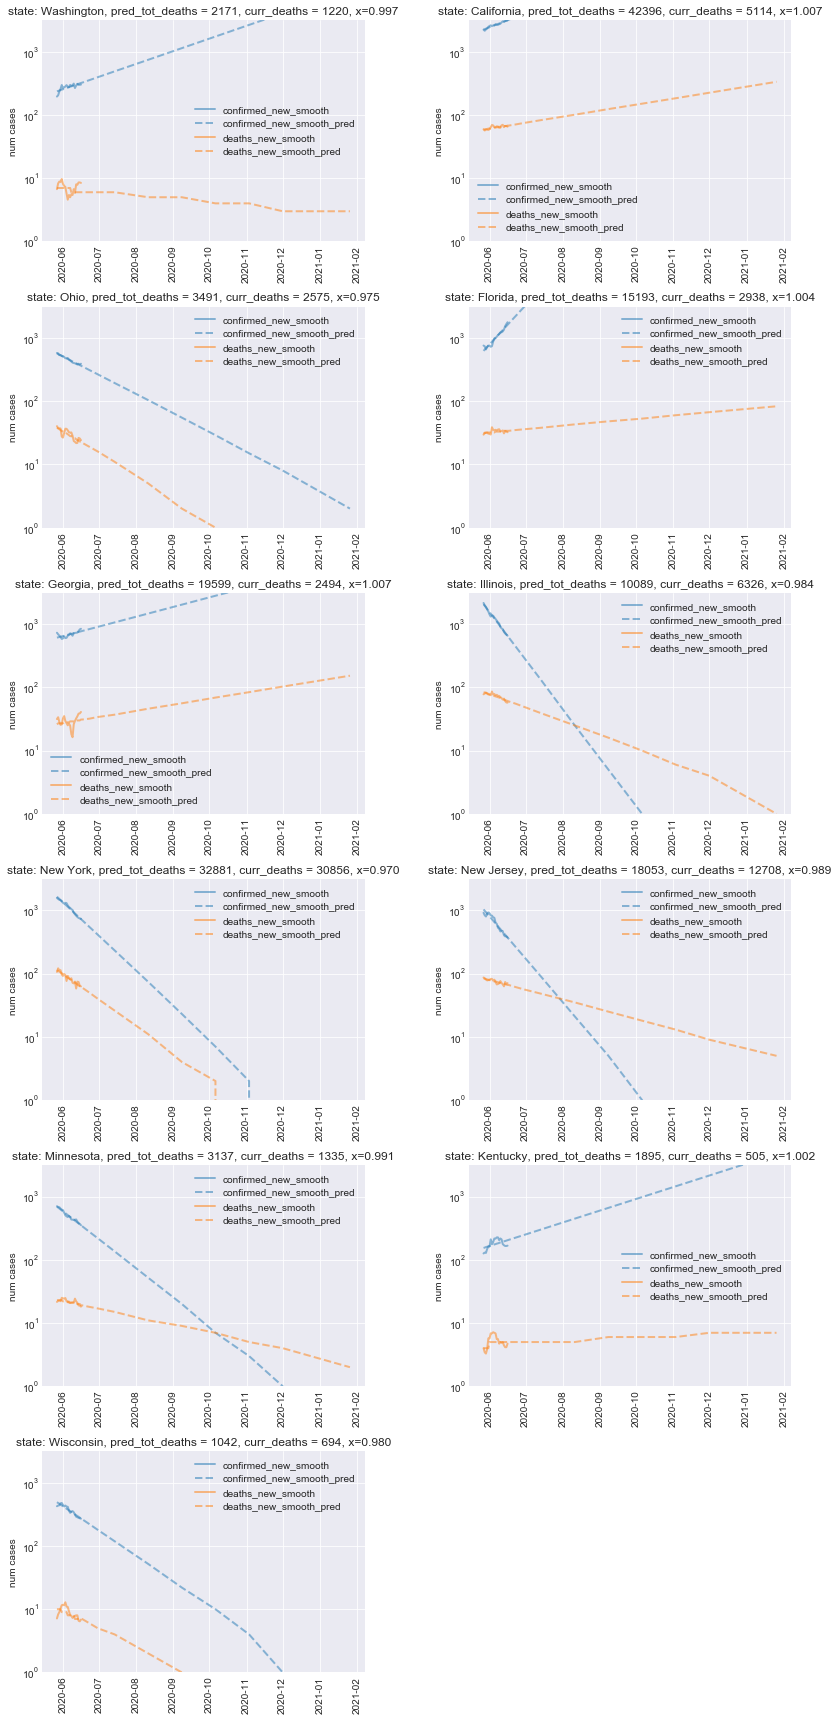

In [822]:
plot_forecasts_new(
    dfp_us_recent_1, 
    col_locale='state', 
    top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin'],
    cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
    cols_deaths='deaths_new_smooth',
)

In [823]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-06-16_n_days_training=21.csv


<a id='us_state_smoothed_trend'></a>
### Plot trends

In [824]:
dfp_us_g_new_confirmed = dfp_us_g[dfp_us_g['date'] > datetime.datetime(2020,4,1)].groupby('state', as_index=False).agg({'confirmed_new': np.sum})
states_minimum_thresh = dfp_us_g_new_confirmed[(dfp_us_g_new_confirmed['confirmed_new'] > 100)].state

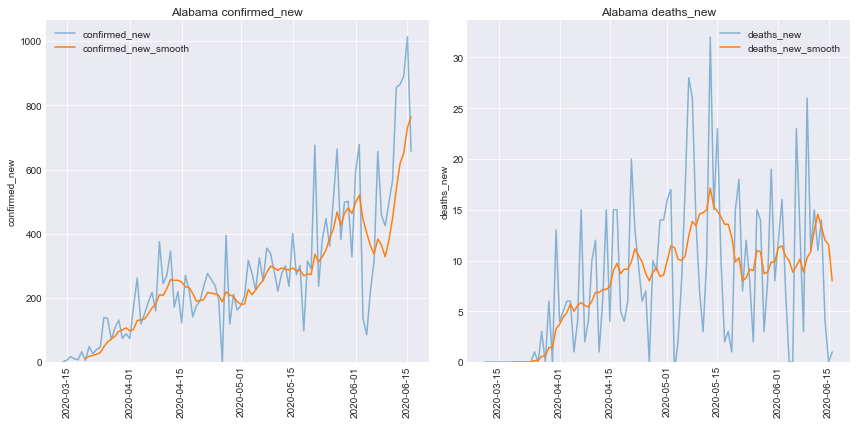

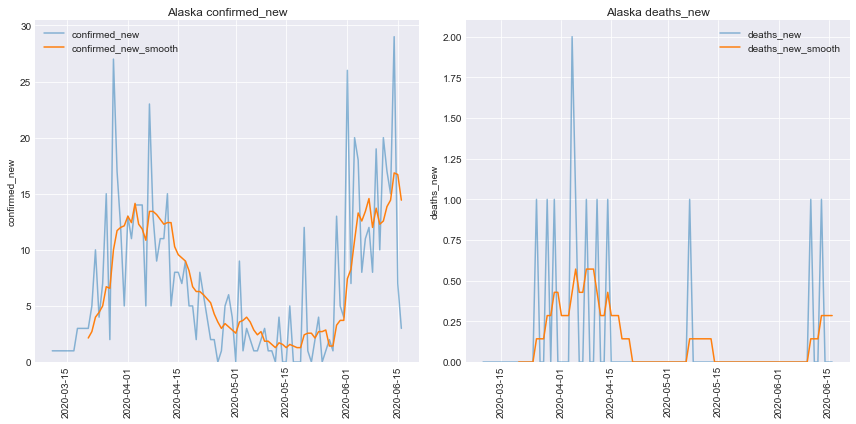

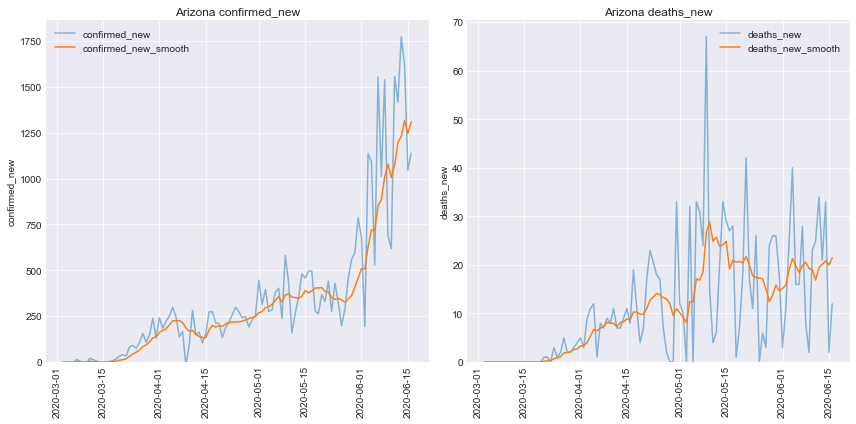

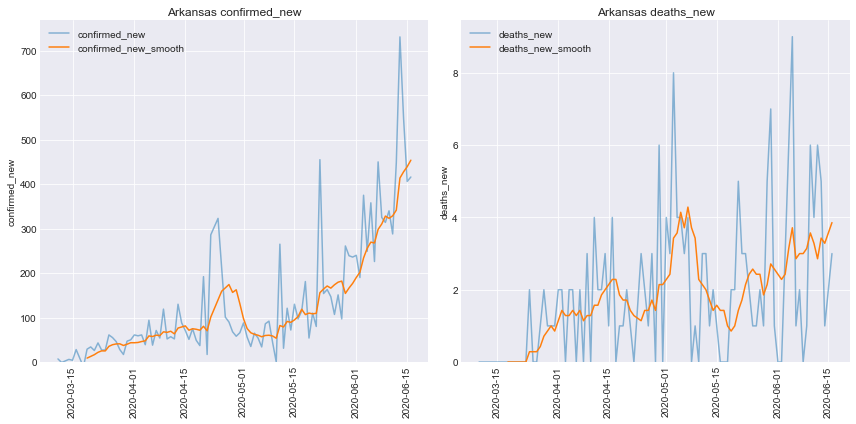

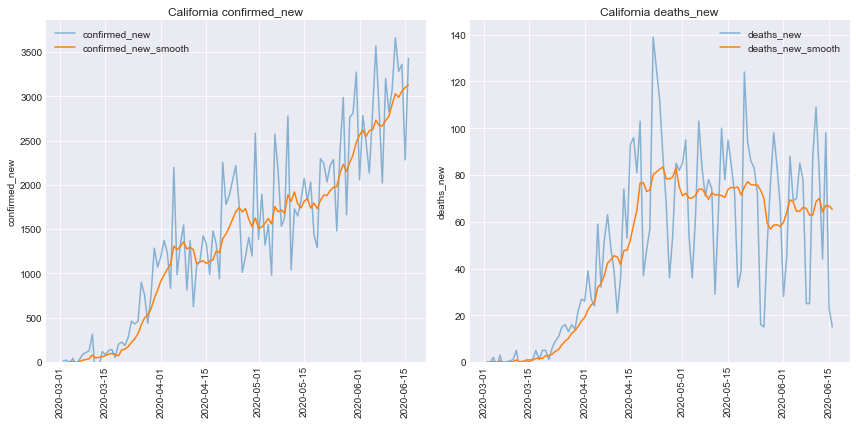

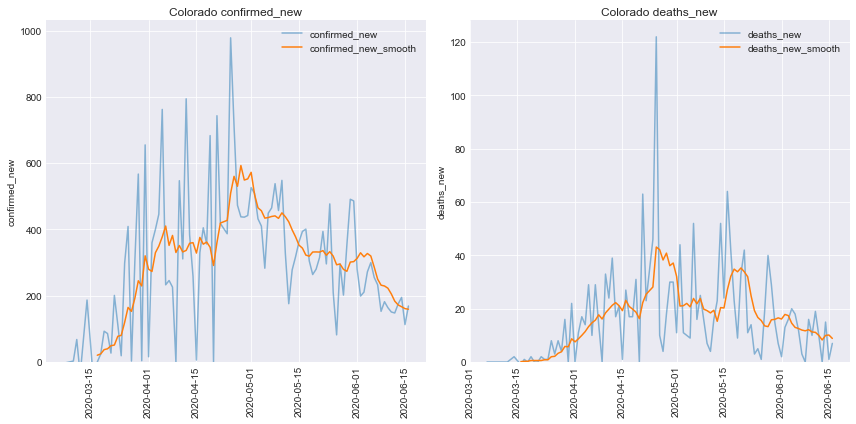

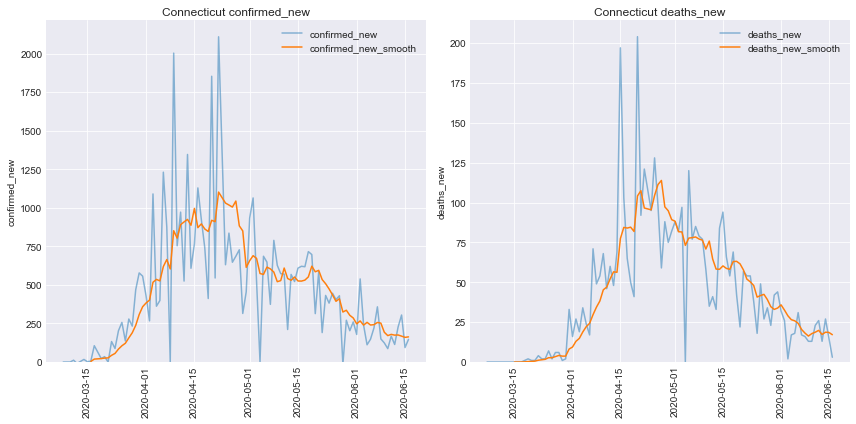

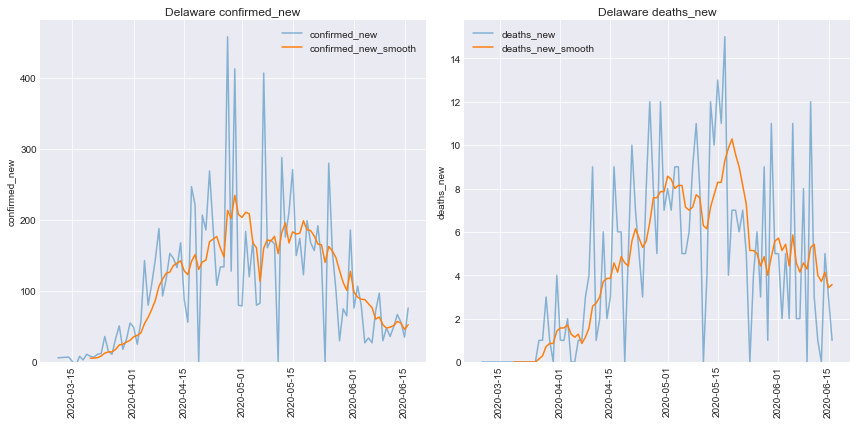

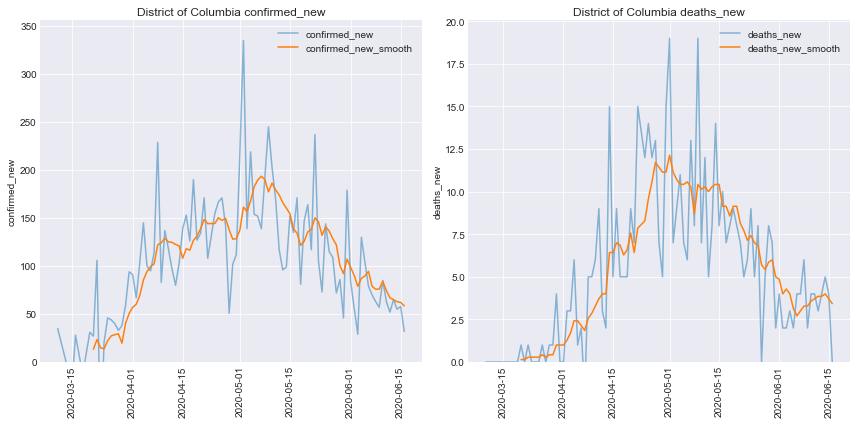

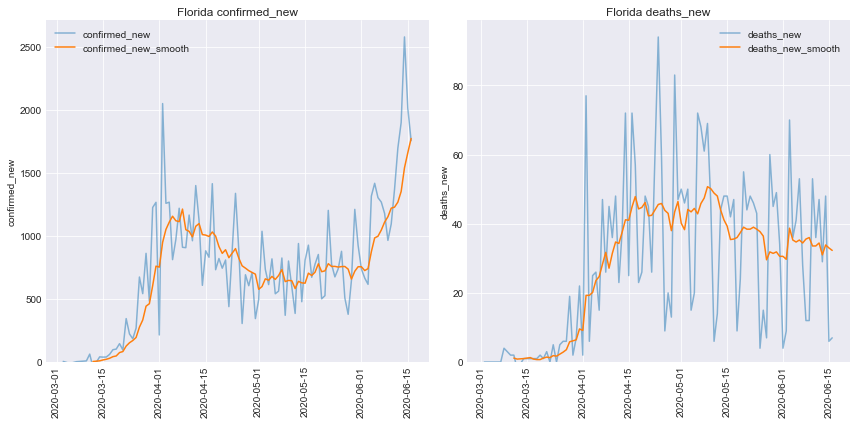

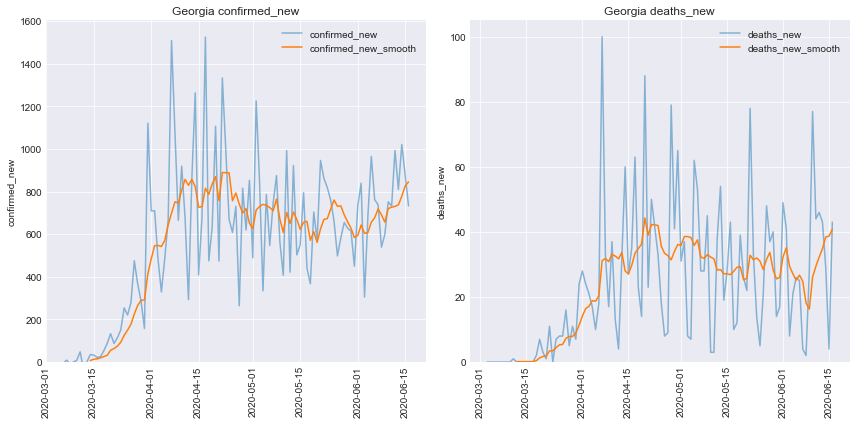

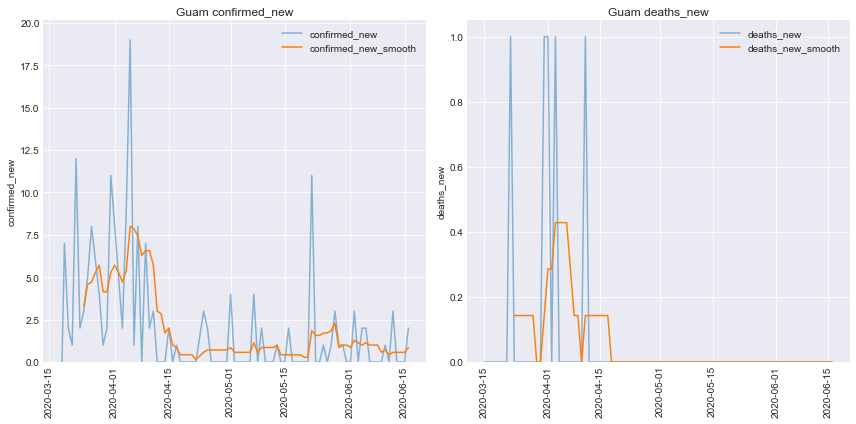

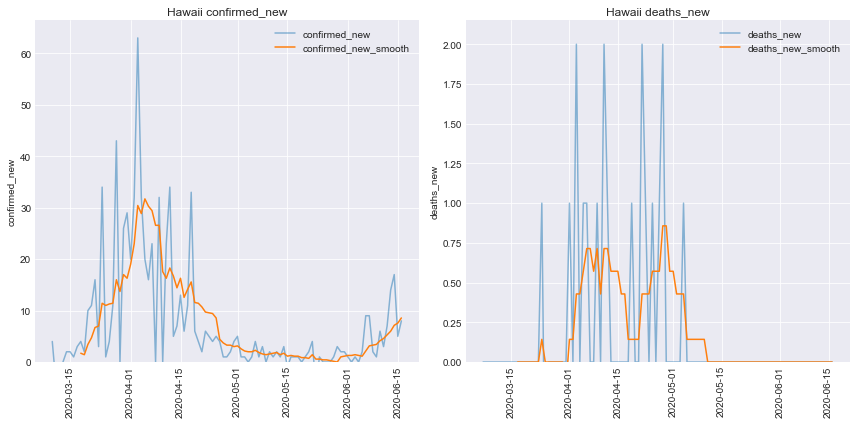

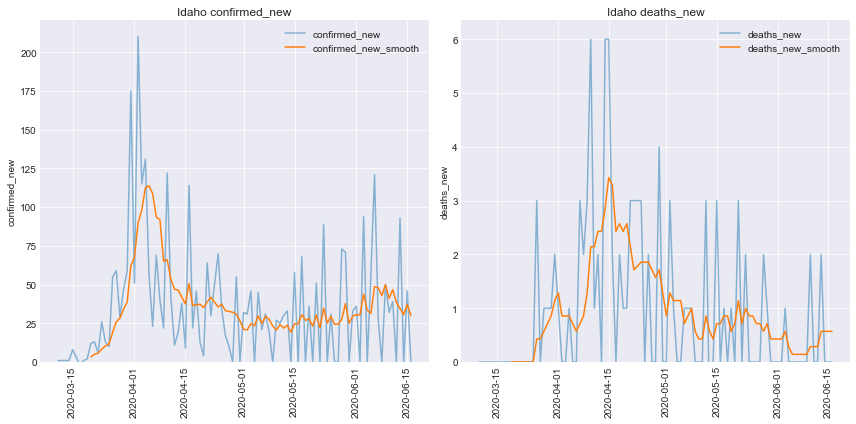

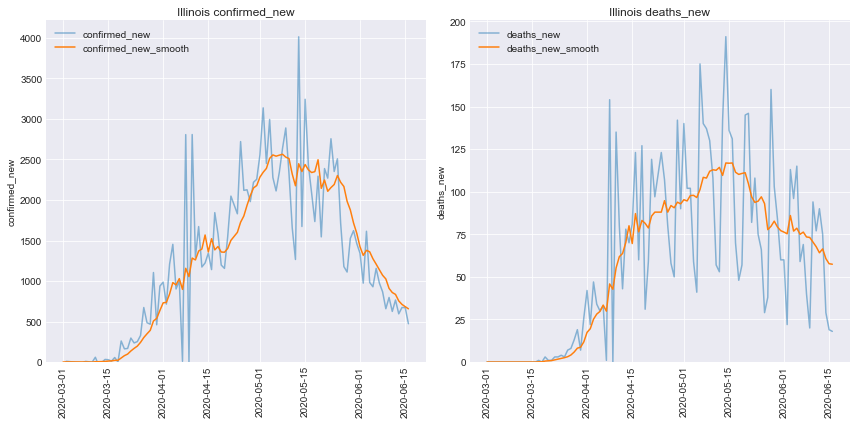

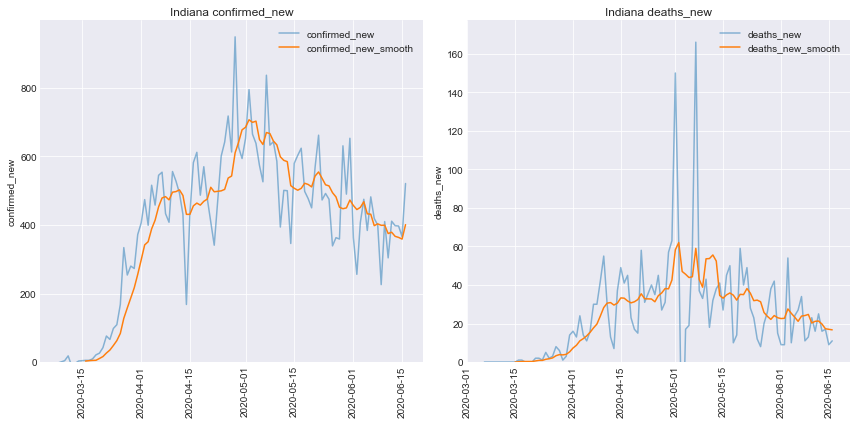

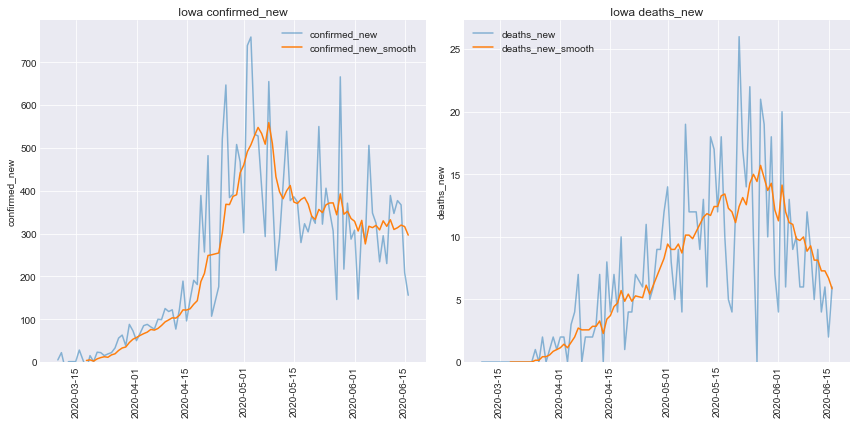

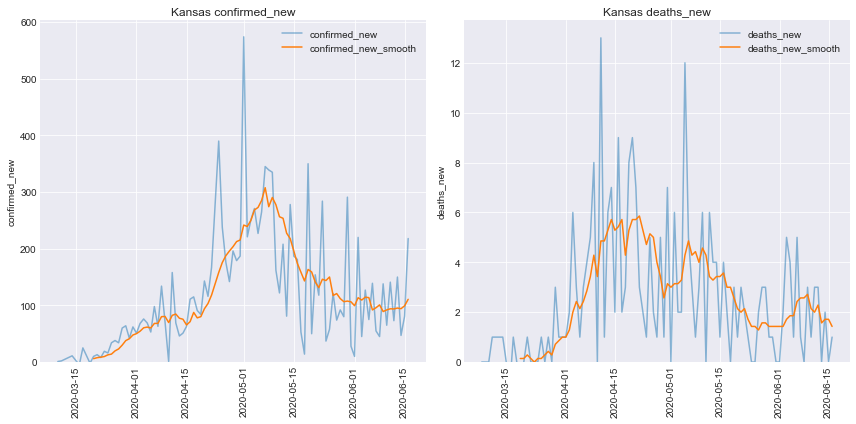

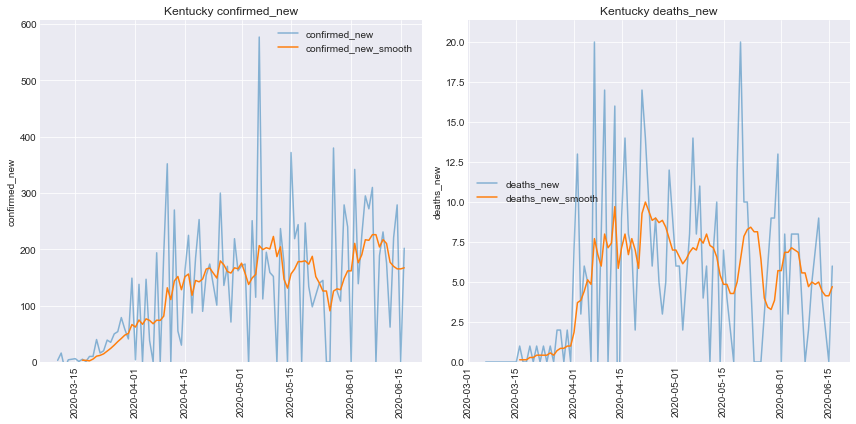

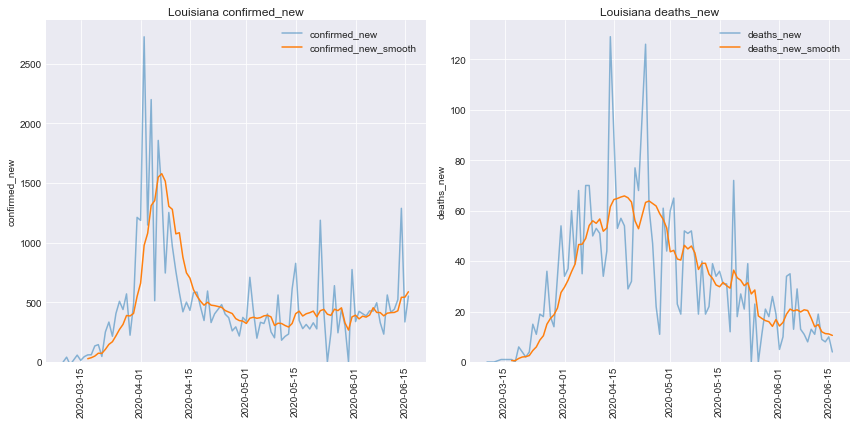

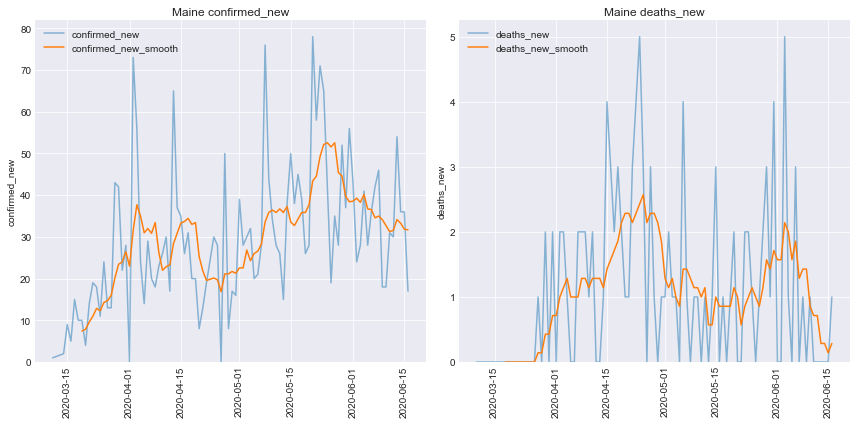

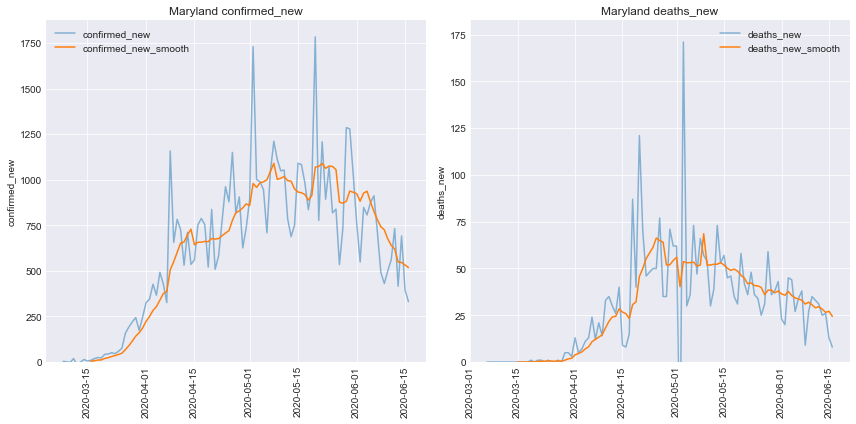

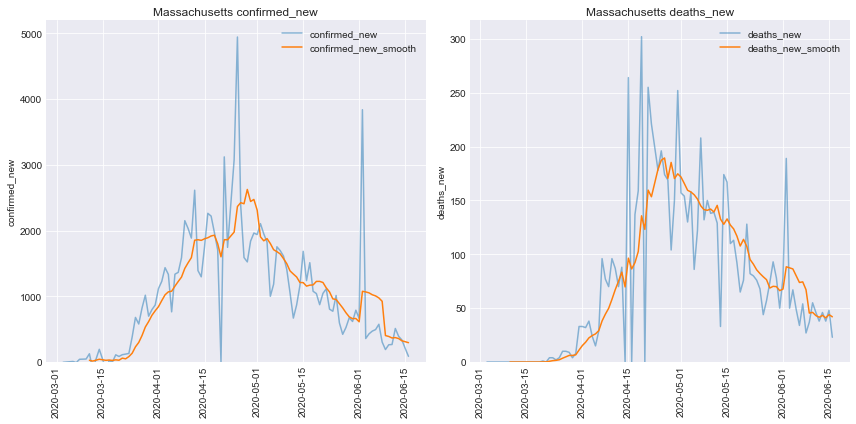

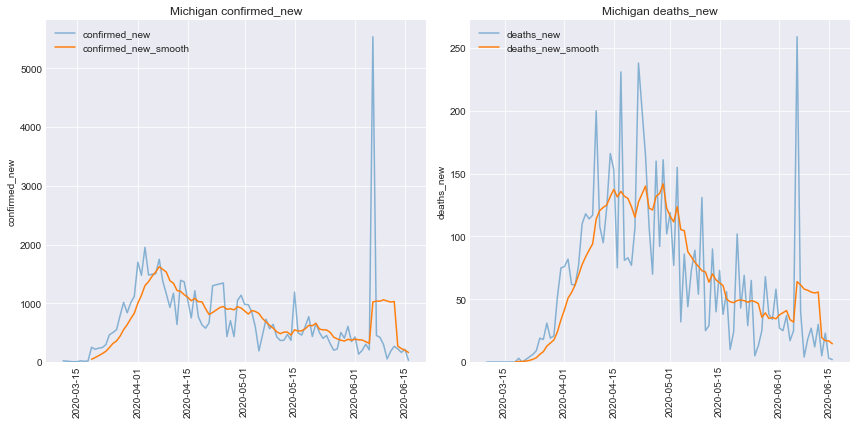

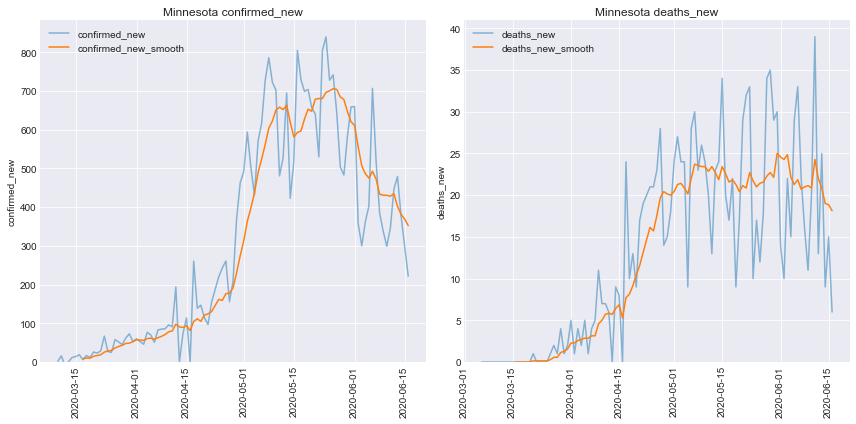

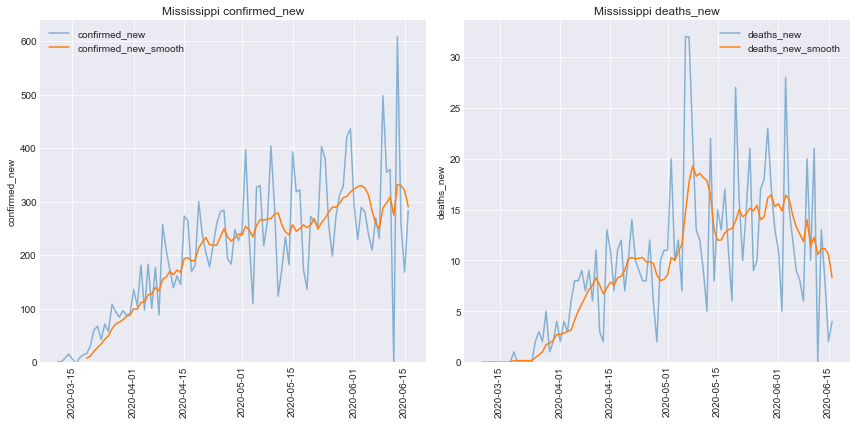

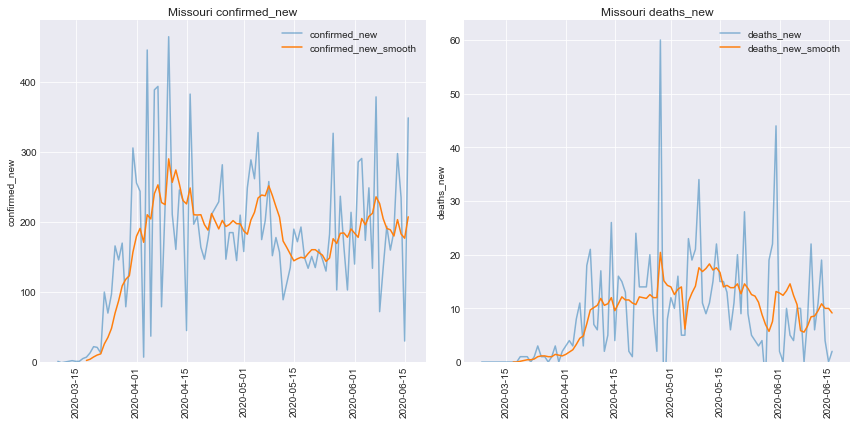

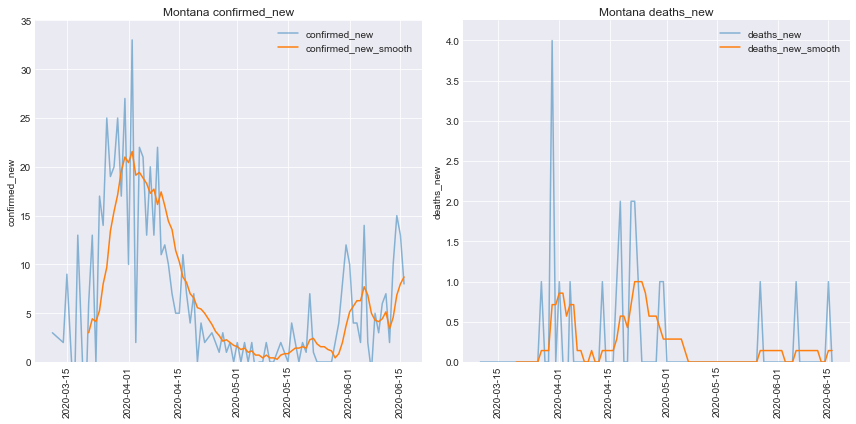

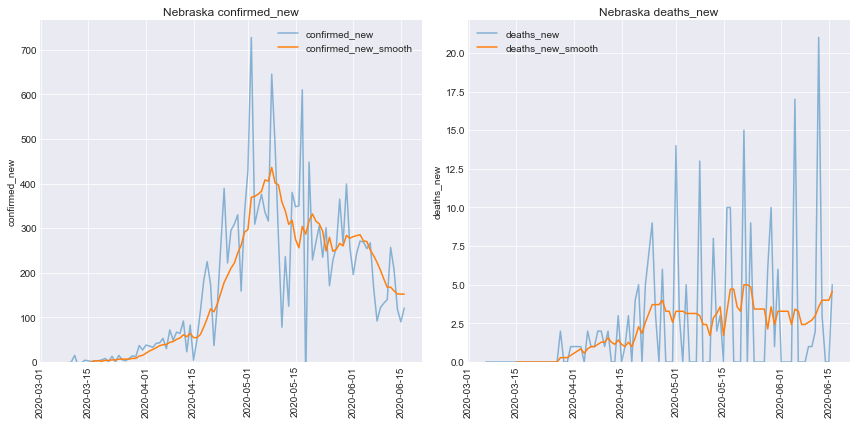

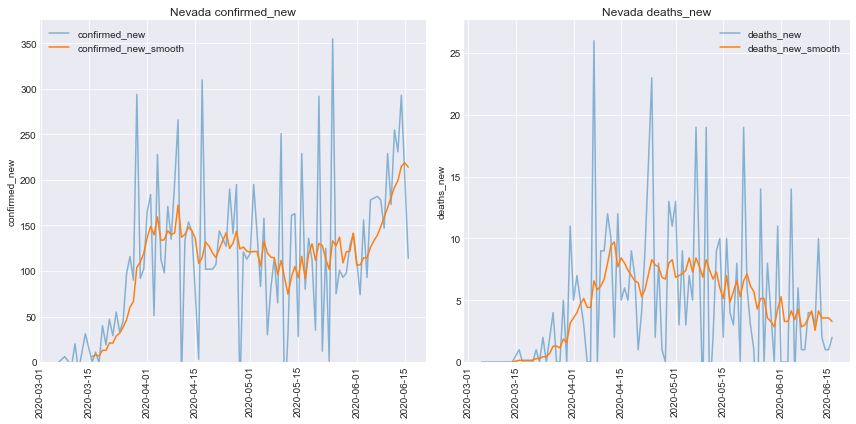

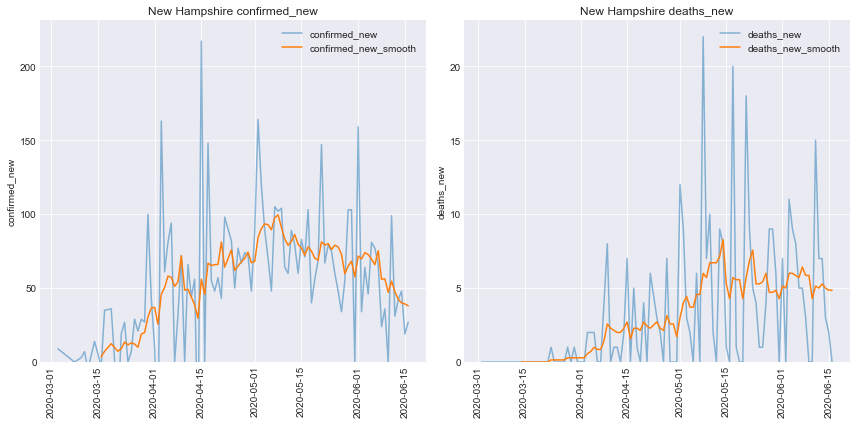

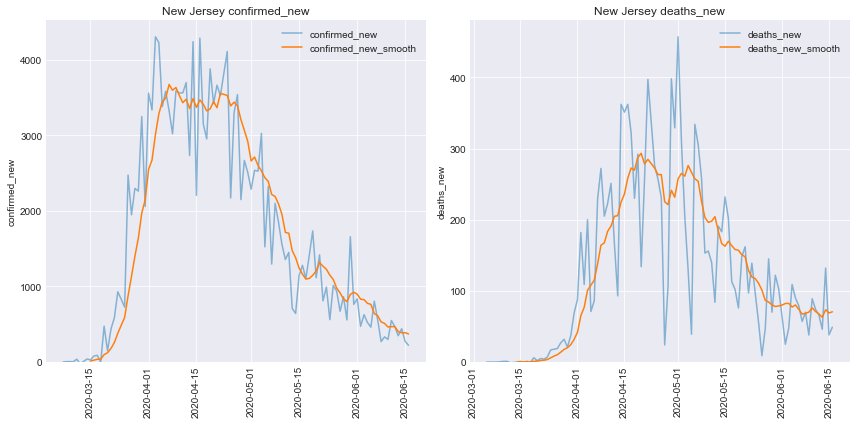

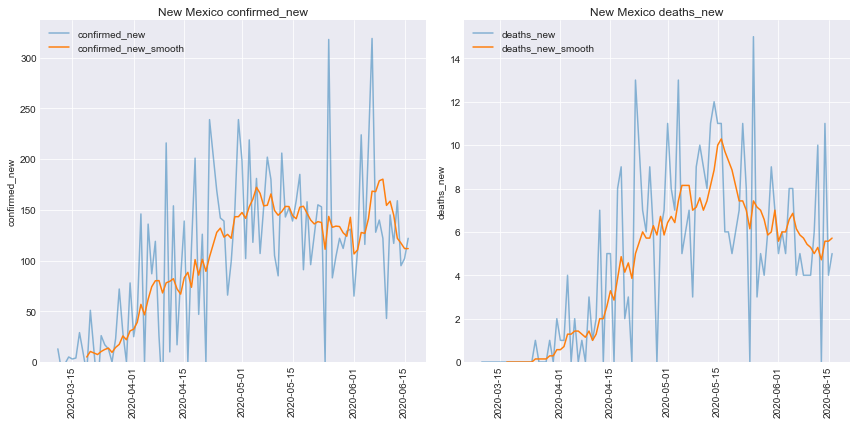

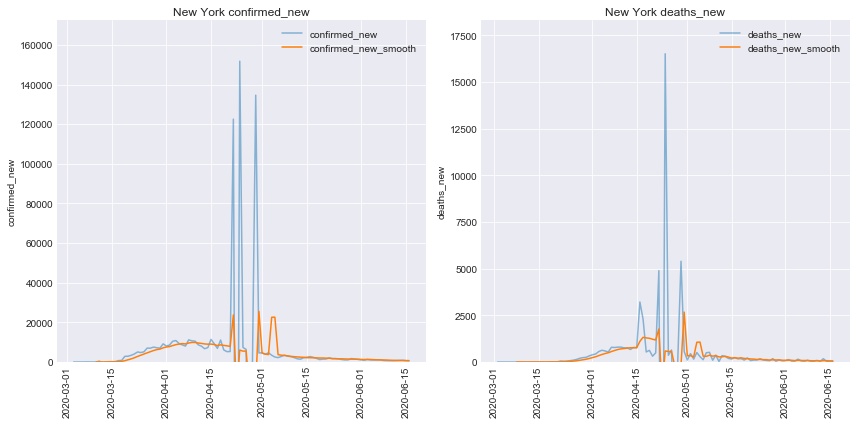

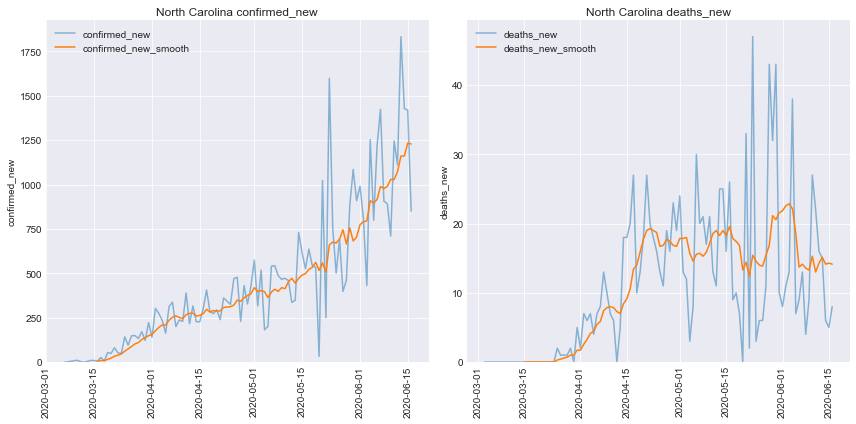

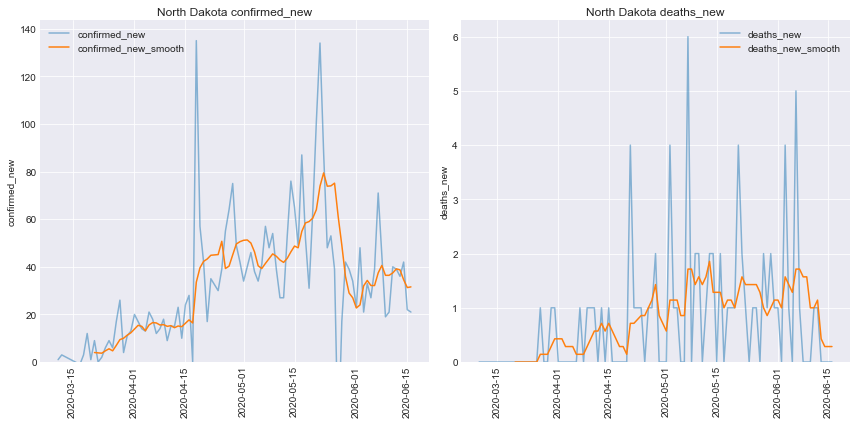

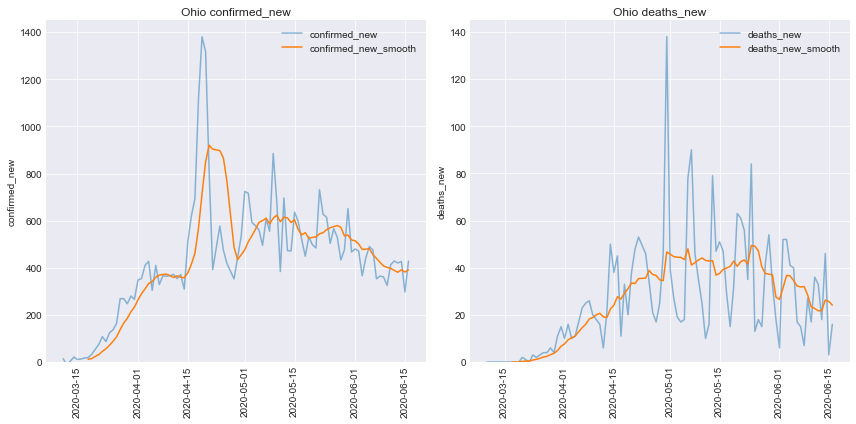

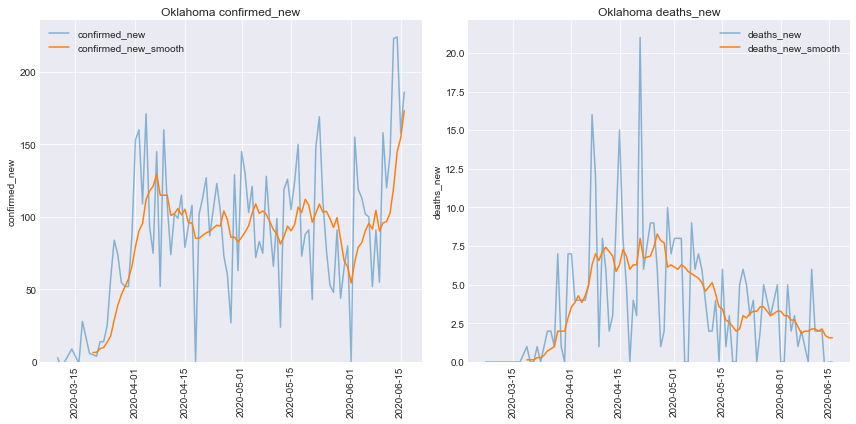

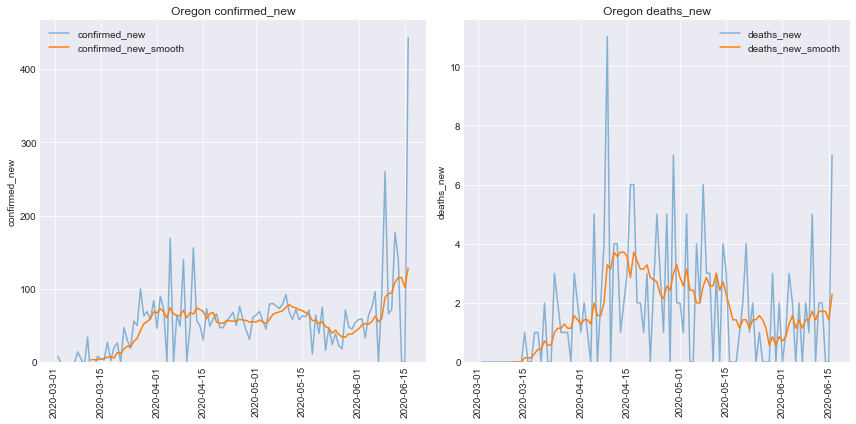

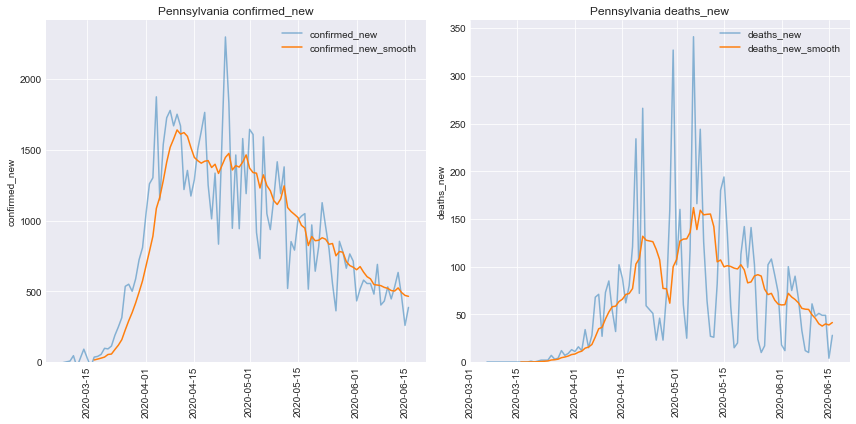

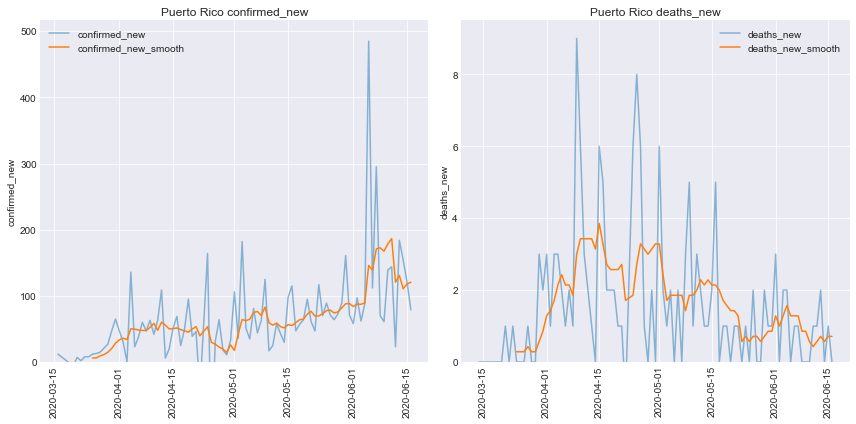

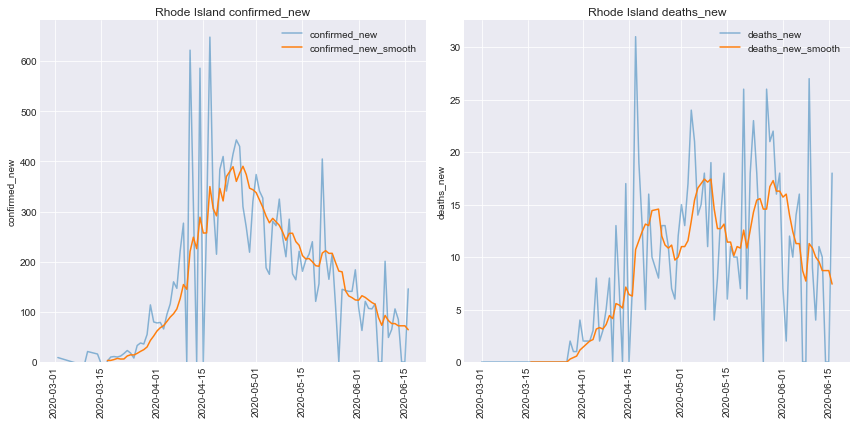

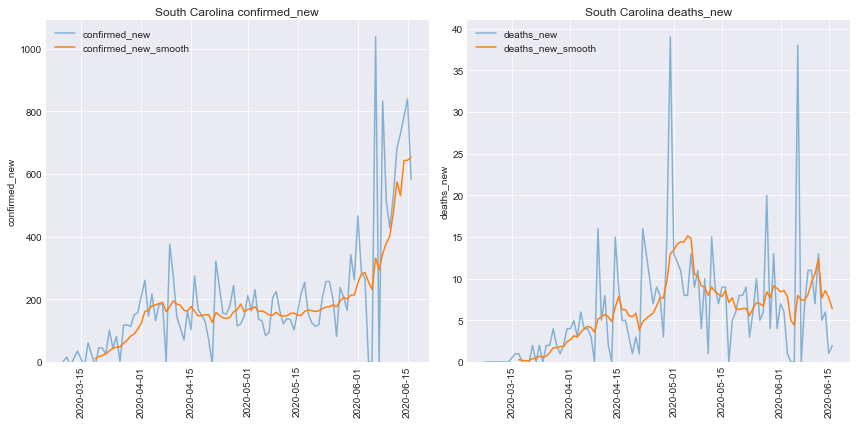

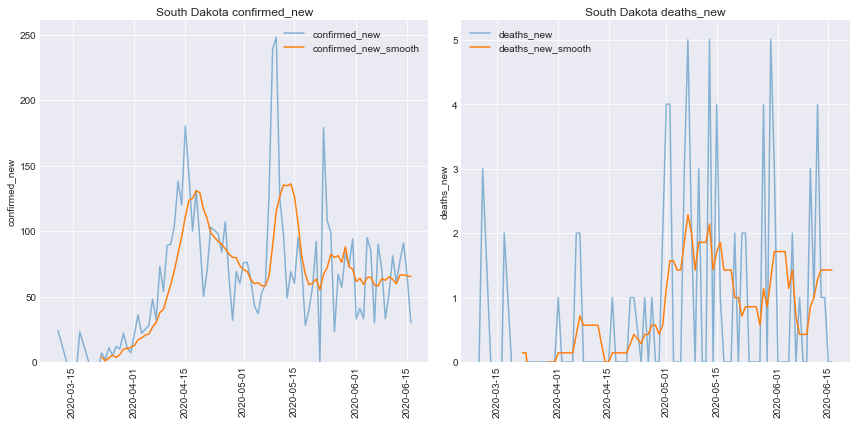

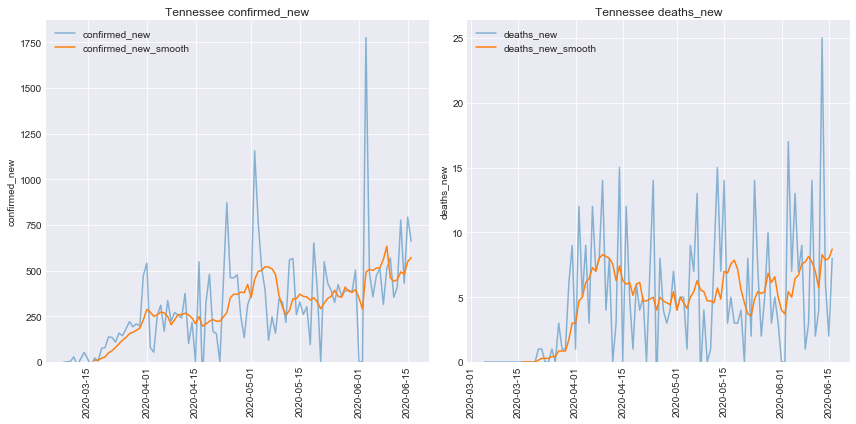

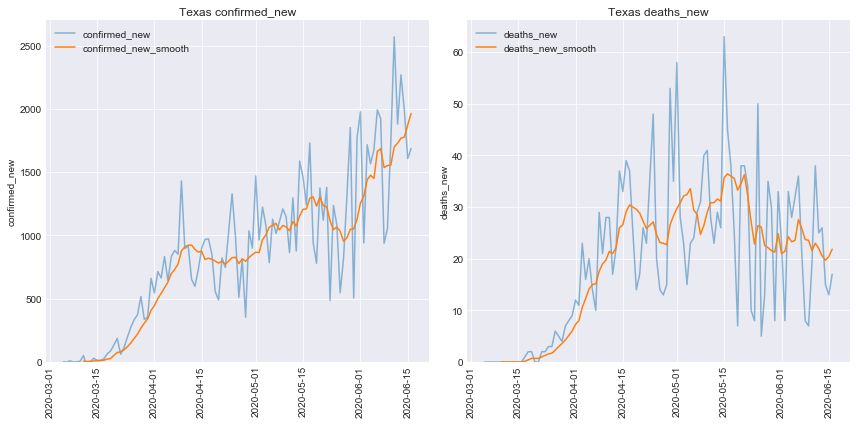

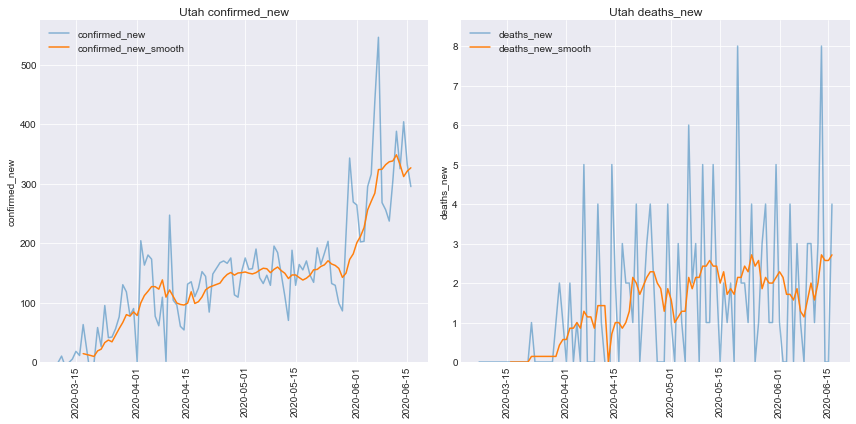

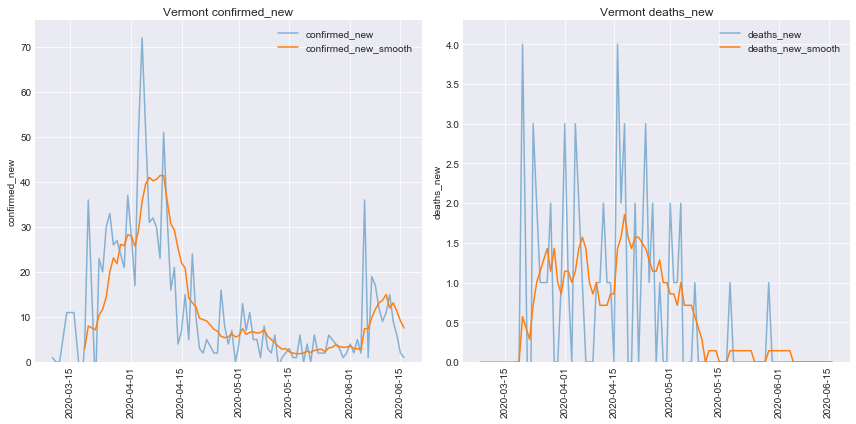

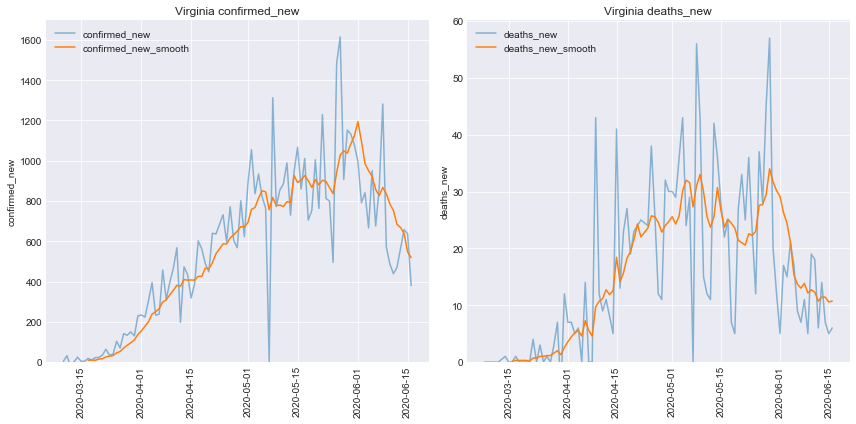

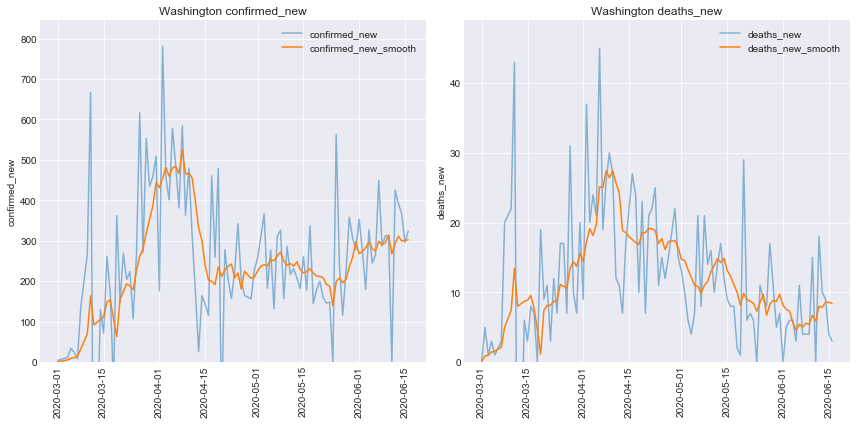

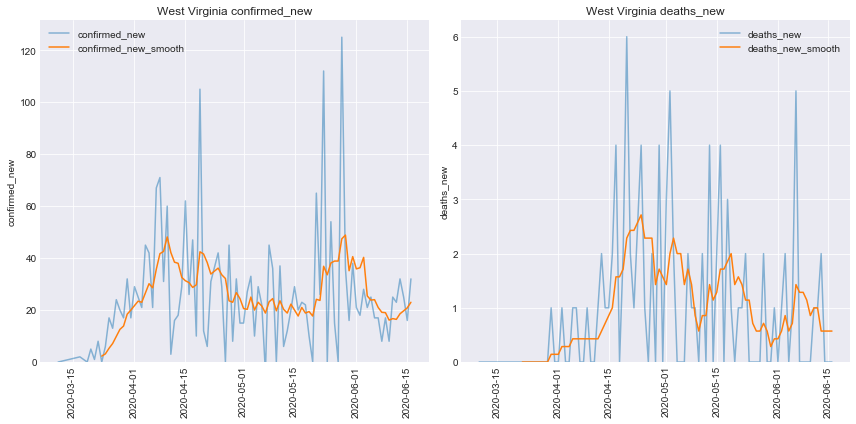

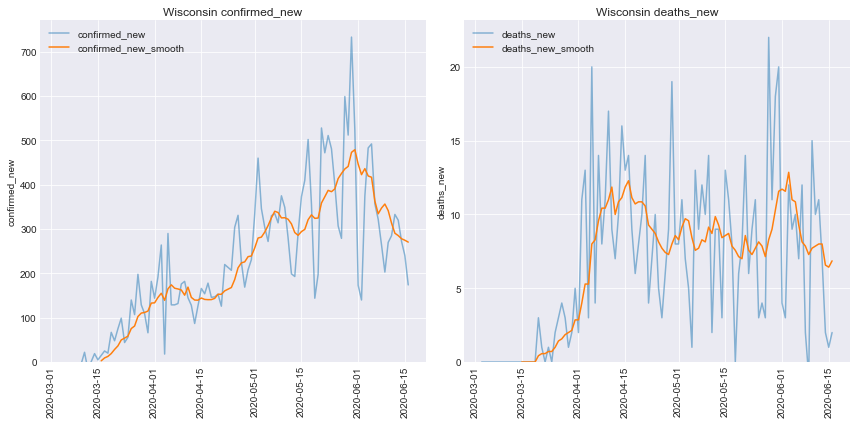

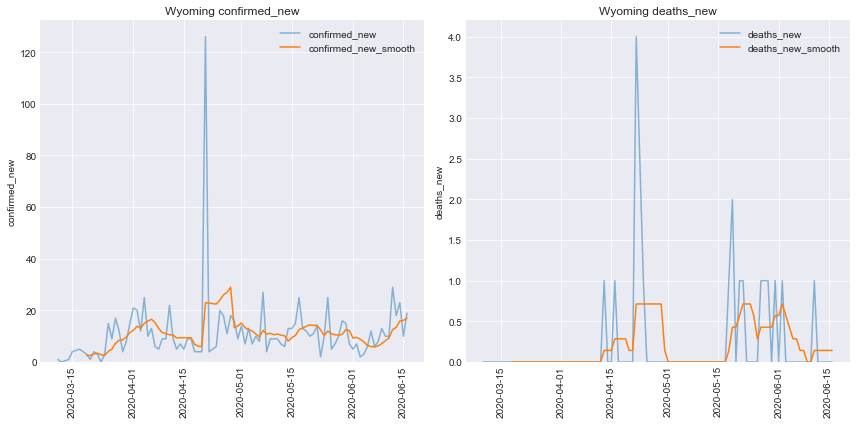

In [825]:
def plot_smoothed_trend(dfp_us_g, states, cols_plot=['confirmed_new'], dt_start=datetime.datetime(2020,3,1)):
    
    for state in states:
        i = 1
        for col_plot in cols_plot:
            plt.subplot(1,len(cols_plot),i)
            col_plot_smooth = f'{col_plot}_smooth'
            dfp_plot = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= dt_start)]
            plt.plot(dfp_plot['date'], dfp_plot[col_plot], alpha=0.5, label=col_plot)
            plt.plot(dfp_plot['date'], dfp_plot[col_plot_smooth], label=col_plot_smooth)
            plt.legend(loc='best')
            plt.xticks(rotation=90)
            plt.ylabel(col_plot)
            plt.title(f'{state} {col_plot}')
            plt.ylim(ymin=0)
            i += 1
        plt.tight_layout()
        plt.show()
    return None

#plot_smoothed_trend(dfp_us_g, ['Washington', 'Ohio', 'California', 'Texas', 'Minnesota', 'Wisconsin'], cols_plot=['confirmed_new', 'deaths_new'])

plot_smoothed_trend(dfp_us_g, states_minimum_thresh, cols_plot=['confirmed_new', 'deaths_new'])

### All states sorted by new deaths DESC

In [826]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                   Arkansas              0.026264                 0.055790
1                  Tennessee              0.024293                 0.020583
2                    Arizona              0.020706                 0.078574
3                     Oregon              0.015199                 0.071659
4                   Nebraska              0.014513                -0.034648
5                     Kansas              0.013644                -0.008688
6                    Alabama              0.008760                 0.016137
7                       Utah              0.007493                 0.046868
8                    Georgia              0.007173                 0.011625
9                 California              0.007127                 0.017233
10            South Carolina              0.004484                 0.067487
11                   Florida              0.003980                 0.048547
12              North Dakota              0.003444                -0.002209
13                  Kentucky              0.001873                 0.014105
14                     Maine              0.001197                -0.019646
15  Northern Mariana Islands              0.000594                 0.000000
16                  Missouri              0.000418                 0.003940
17                 Recovered              0.000000                 0.000000
18                   Vermont              0.000000                 0.086692
19                    Alaska              0.000000                 0.110340
20            Virgin Islands              0.000000                 0.000000
21                   Montana              0.000000                 0.037611
22                   Wyoming              0.000000                 0.014029
23                      Guam              0.000000                -0.010830
24            Grand Princess              0.000000                 0.000000
25                    Hawaii              0.000000                 0.071611
26                     Idaho              0.000000                 0.015119
27          Diamond Princess              0.000000                 0.000000
28             West Virginia             -0.000459                -0.050367
29               Puerto Rico             -0.000521                 0.034572
30             New Hampshire             -0.000650                -0.029149
31              South Dakota             -0.000937                -0.009276
32                     Texas             -0.002876                 0.034497
33                Washington             -0.003299                 0.015219
34                    Nevada             -0.007385                 0.035320
35                 Minnesota             -0.009223                -0.033274
36                New Jersey             -0.011403                -0.049815
37                New Mexico             -0.011716                 0.001462
38                  Delaware             -0.012916                -0.054687
39                  Illinois             -0.015745                -0.056001
40                   Indiana             -0.015903                -0.013537
41                 Louisiana             -0.016268                 0.017854
42                 Wisconsin             -0.019885                -0.029094
43                  Maryland             -0.020452                -0.030616
44            North Carolina             -0.022128                 0.031144
45                  Michigan             -0.022458                 0.001392
46      District of Columbia             -0.024698                -0.032184
47               Mississippi             -0.024756                -0.001097
48                      Ohio             -0.025035                -0.022090
49                  Colorado             -0.029821                -0.035216
50                  New York             -0.030098                -0.039931
51              Pennsylvania             -0.033177                -0.02

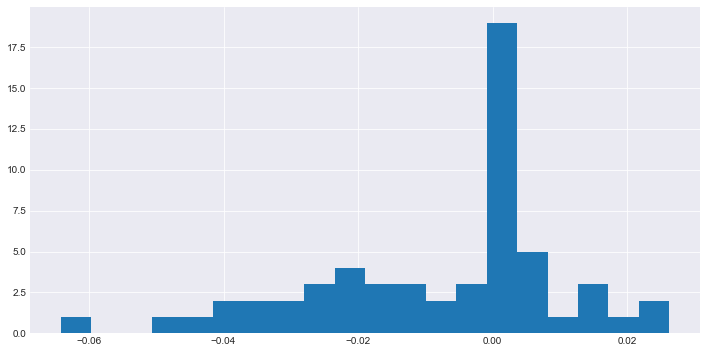

In [827]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

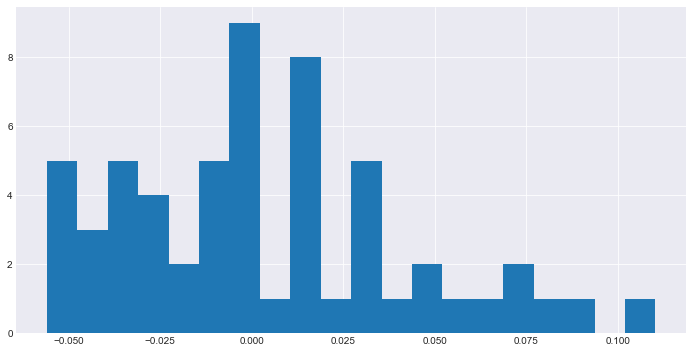

In [828]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [829]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0    Arkansas              0.026264                 0.055790
1   Tennessee              0.024293                 0.020583
2     Arizona              0.020706                 0.078574
3      Oregon              0.015199                 0.071659
4    Nebraska              0.014513                -0.034648
5      Kansas              0.013644                -0.008688
6     Alabama              0.008760                 0.016137
7        Utah              0.007493                 0.046868
8     Georgia              0.007173                 0.011625
9  California              0.007127                 0.017233

### Which states are increasing in new deaths <u>least</u> quickly?

In [830]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48           Ohio             -0.025035                -0.022090
49       Colorado             -0.029821                -0.035216
50       New York             -0.030098                -0.039931
51   Pennsylvania             -0.033177                -0.024866
52  Massachusetts             -0.035552                -0.052970
53       Oklahoma             -0.039054                 0.034450
54   Rhode Island             -0.039852                -0.043992
55           Iowa             -0.042783                -0.006359
56    Connecticut             -0.046704                -0.040577
57       Virginia             -0.064216                -0.034895

### Is there a day-of-the-week effect on new deaths?

In [831]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [832]:
deaths_new_col, death_pred_col = 'deaths_new', 'deaths_new_smooth_pred'
confirmed_new_col, confirmed_pred_col = 'confirmed_new', 'confirmed_new_smooth_pred'
dfp_us_dow['death_delta'] = dfp_us_dow[deaths_new_col]- dfp_us_dow[death_pred_col]
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow[death_pred_col]

dfp_us_dow['confirmed_delta'] = dfp_us_dow[confirmed_new_col]- dfp_us_dow[confirmed_pred_col]
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow[confirmed_pred_col]
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.mean, # np.median
                          deaths_new_col: np.mean, 
                          death_pred_col: np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.mean}) # np.median
                    )

In [833]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -3.666667        -0.555556    2.666667   
379  Washington    1    -2.333333        -0.373016    4.000000   
380  Washington    2     3.000000         0.500000    9.666667   
381  Washington    3     1.000000         0.095238    7.666667   
382  Washington    4     4.000000         0.666667   10.666667   
383  Washington    5     2.000000         0.317460    8.666667   
384  Washington    6     0.000000         0.023810    6.666667   

     deaths_new_smooth_pred  confirmed_delta  confirmed_rel_delta  
378                6.333333        27.000000             0.110529  
379                6.333333        14.333333             0.051485  
380                6.666667       -61.333333            -0.252626  
381                6.666667       -84.000000            -0.279260  
382                6.666667        70.333333             0.259519  
383                6.666667        44.333333             0.158490  
384                6.666667        83.666667             0.295603

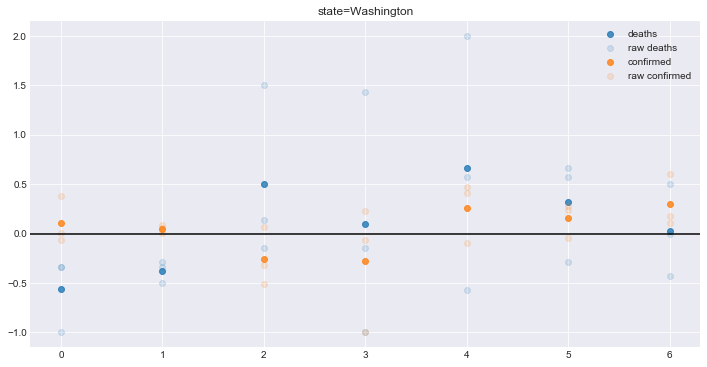

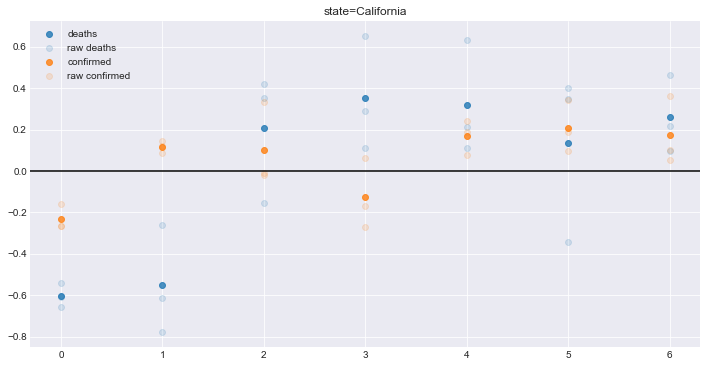

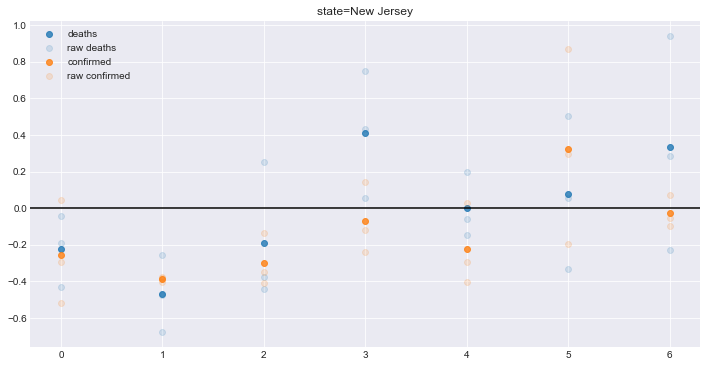

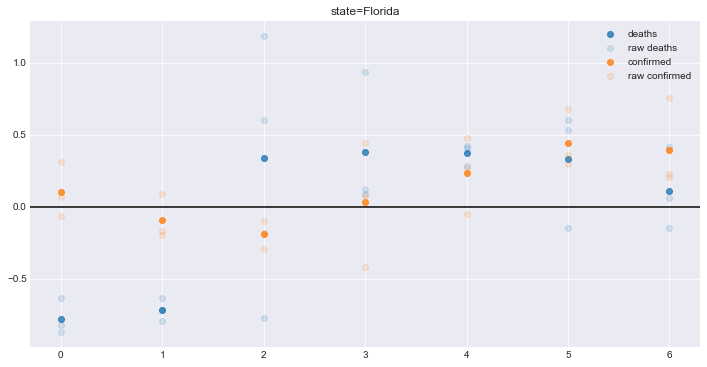

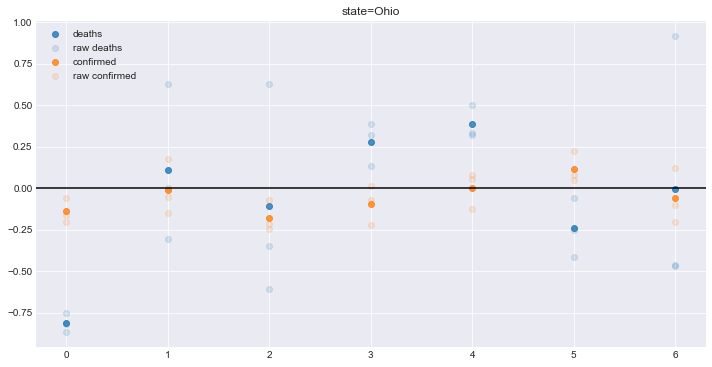

In [834]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()